# Fear Prediction with Audio and Visual Features and Low Level Cinematographic Features

The Mediaeval 2017 Emotional Impact of Movies Task includes the data in the emotional domain 
(valence - arousal  regression) and  fear ( binary classification).
We have displayed the valence and arousal of all the movies in the dataset.
Also the time of the movie where fear is present is specified with the value of the second.
According to the Russell's circumplex model we were expecting the "FEAR" to be appeared in the negative vallence, positive arousal part of the circumflex.
However in some movies, we can see that frightment exists in positive valence with negative arousal also.


In [1]:

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import matplotlib.colors as colors


import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import numpy as np
import pylab as pl
import re, fileinput
import os.path
import glob
import pickle
import sys


In [2]:
import numpy as np 
print(np.__version__) 
print(np.__path__)


1.11.3
['/home/yt/anaconda2/lib/python2.7/site-packages/numpy']


In [3]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
from scipy.stats import pearsonr


In [4]:
#Dev data
#movieNames = ['After_The_Rain','Attitude_Matters','Barely_legal_stories','Between_Viewings','Big_Buck_Bunny','Chatter','Cloudland','Damaged_Kung_Fu','Decay','Elephant_s_Dream','First_Bite','Full_Service','Islands','Lesson_Learned','Norm','Nuclear_Family','On_time','Origami','Parafundit','Payload','Riding_The_Rails','Sintel','Spaceman','Superhero','Tears_of_Steel','The_room_of_franz_kafka','The_secret_number','To_Claire_From_Sonny','Wanted','You_Again']

pathcontinuous = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/ContinuousLIRIS-ACCEDE/"
continuousAnnotationsFolder = pathcontinuous +'continuous-annotations/'
devdatacontinous =  pathcontinuous + "continuous-movies/"
pathcontfeatures = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/Continuous/features-out/"

datahome = '/home/yt/Desktop/mediaeval2017'

med2017visualFeaturesfolder='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Visual_features/MEDIAEVAL17-DevSet-Visual_features/features/'
med2017audiofolder='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Audio_features/MEDIAEVAL17-DevSet-Audio_features/features/'
med2017annotationsFolder = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Valence_Arousal-annotations/MEDIAEVAL17-DevSet-Valence_Arousal-annotations/annotations/'
med2017fearFolder = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-DevSet-Fear-annotations/MEDIAEVAL17-DevSet-Fear-annotations/annotations/'
med2017dataFolder = devdatacontinous

### Test Data
med2017visualfolderTest='/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Visual_features/MEDIAEVAL17-TestSet-Visual_features/visual_features/'
med2017audiofolderTest = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Audio_features/MEDIAEVAL17-TestSet-Audio_features/audio_features/'
med2017datafolderTest = '/home/yt/Desktop/mediaeval2017/MEDIAEVAL17-TestSet-Data/MEDIAEVAL17-TestSet-Data/data/'

med2017testfeatures = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/Continuous/features-out/"

facesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/dlibfaces/'
framesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/movframes/'
openfacesfolder = '/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/faceinfo/'
faceslandmarksfolder = '/home/yt/cinevis/data/dlibfaceslandmarks/'

#frame-%05d.jpg

In [5]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

def displayframe(movie,number):
    filename = framesfolder+movie +'.mp4-'+ '{0:05d}'.format(number) +'.jpg'

    img=mpimg.imread(filename)
    plt.figure(figsize=(20,30))
    plt.grid(False)
    
    imgplot = plt.imshow(img)
    plt.show()


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


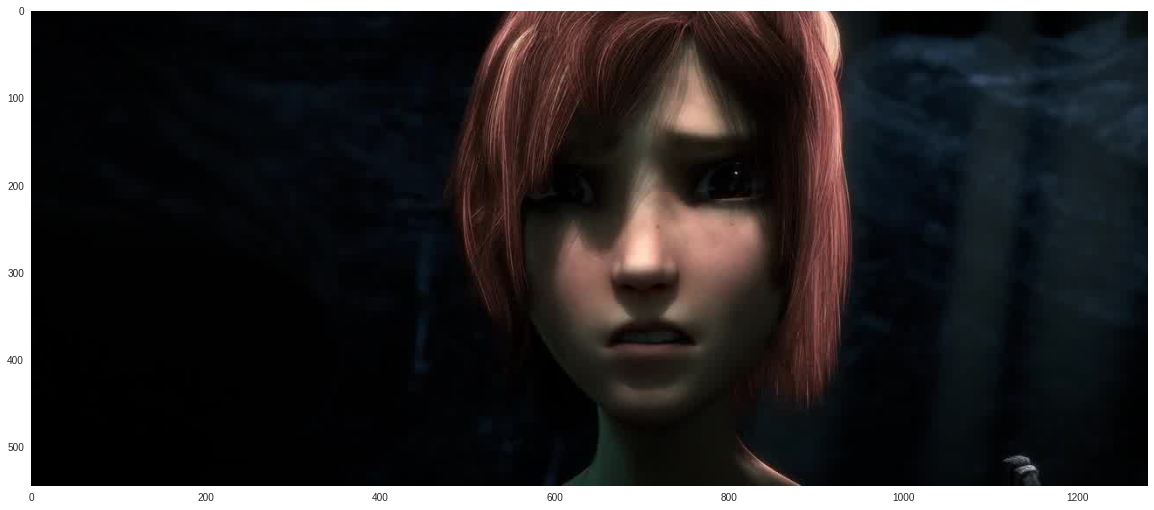

In [6]:
displayframe('Sintel',623)

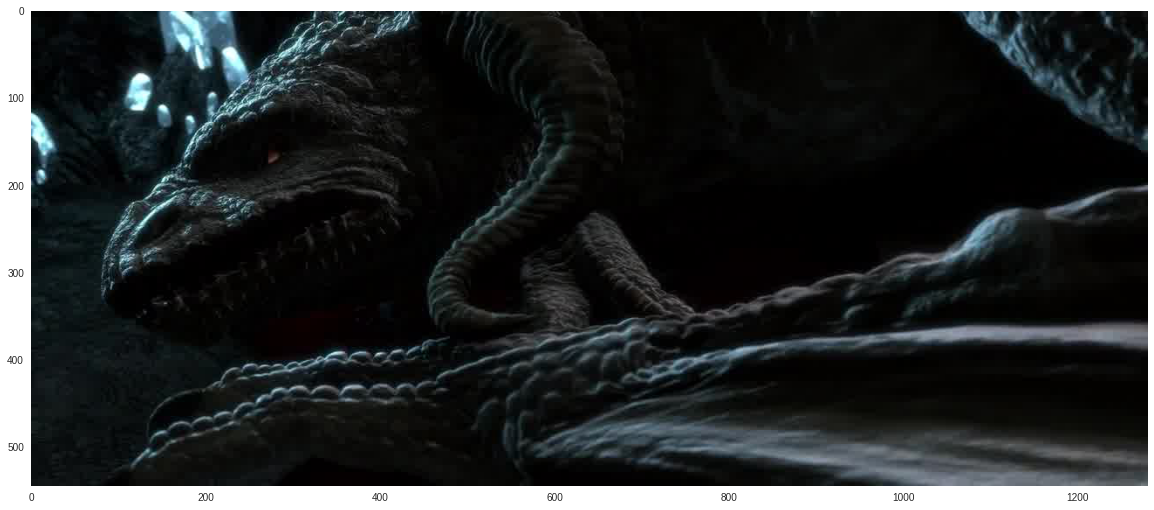

In [7]:
displayframe('Sintel',627)

In [8]:
files = glob.glob(med2017datafolderTest+'*')
testmovieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [9]:
files = glob.glob(med2017dataFolder+'*')
movieNames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [18]:
movieNames,testmovieNames

(['After_The_Rain',
  'Attitude_Matters',
  'Barely_legal_stories',
  'Between_Viewings',
  'Big_Buck_Bunny',
  'Chatter',
  'Cloudland',
  'Damaged_Kung_Fu',
  'Decay',
  'Elephant_s_Dream',
  'First_Bite',
  'Full_Service',
  'Islands',
  'Lesson_Learned',
  'Norm',
  'Nuclear_Family',
  'On_time',
  'Origami',
  'Parafundit',
  'Payload',
  'Riding_The_Rails',
  'Sintel',
  'Spaceman',
  'Superhero',
  'Tears_of_Steel',
  'The_room_of_franz_kafka',
  'The_secret_number',
  'To_Claire_From_Sonny',
  'Wanted',
  'You_Again'],
 ['MEDIAEVAL17_00',
  'MEDIAEVAL17_01',
  'MEDIAEVAL17_02',
  'MEDIAEVAL17_03',
  'MEDIAEVAL17_04',
  'MEDIAEVAL17_05',
  'MEDIAEVAL17_06',
  'MEDIAEVAL17_07',
  'MEDIAEVAL17_08',
  'MEDIAEVAL17_09',
  'MEDIAEVAL17_10',
  'MEDIAEVAL17_11',
  'MEDIAEVAL17_12',
  'MEDIAEVAL17_13'])

In [11]:
def getfacedf(moviename):
    filename = facesfolder + moviename +'.mp4-faces.txt'
    df = pd.read_csv(filename,sep=' ')
    
    df['topratio'] = df['top']/df['hframe'] 
    df['bottomratio'] = df['bottom']/df['hframe'] 
    df['leftratio'] = df['left']/df['wframe'] 
    df['rightratio'] = df['right']/df['wframe']
    df['fheight'] =  (df['bottom']-df['top'])/df['hframe'] 
    df['fwidth'] =  (df['right']-df['left'])/df['wframe'] 
    df['farea'] = df['fheight']*df['fwidth']
    df['fcx'] = df['fheight'] / 2
    df['fcy'] = df['fwidth'] / 2
    
    #df[ df['noface']>0]
    cols = ['noface','fcx','fcy','topratio','bottomratio','leftratio','rightratio','fheight','fwidth','farea']
    return df[cols]

In [14]:
def getfacelandmarksdf(moviename):
    filename = faceslandmarksfolder + moviename +'.mp4-faces-landmarks.txt'
    df = pd.read_csv(filename,sep=' ')
    df = df.fillna(0)
    return df

In [17]:
getfacelandmarksdf('Chatter').describe()


id  noface    top        left      bottom       right  \
count  511.000000   511.0  511.0  511.000000  511.000000  511.000000   
mean   255.000000   272.0  640.0    0.424658    0.066551    0.166469   
std    147.657261     0.0    0.0    0.532934    0.109917    0.223531   
min      0.000000   272.0  640.0    0.000000    0.000000    0.000000   
25%    127.500000   272.0  640.0    0.000000    0.000000    0.000000   
50%    255.000000   272.0  640.0    0.000000    0.000000    0.000000   
75%    382.500000   272.0  640.0    1.000000    0.117647    0.325000   
max    510.000000   272.0  640.0    2.000000    0.606618    0.787500   

           hframe      wframe           0           1     ...             134  \
count  511.000000  511.000000  511.000000  511.000000     ...      511.000000   
mean     0.231941    0.237543    0.216160    0.170132     ...        0.208736   
std      0.297646    0.298906    0.286556    0.228186     ...        0.278459   
min      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
25%      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
50%      0.000000    0.000000    0.000000    0.000000     ...        0.000000   
75%      0.492647    0.529687    0.475781    0.393382     ...        0.453906   
max      1.000000    0.934375    0.937500    0.790441     ...        0.932813   

              135         136         137         138         139         140  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean     0.092768    0.212781    0.086746    0.217191    0.082882    0.221698   
std      0.132054    0.282966    0.125404    0.287976    0.121120    0.293088   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.198529    0.468750    0.181985    0.482031    0.172794    0.495312   
max      0.599265    0.939063    0.584559    0.946875    0.577206    0.954688   

              141         142         143  
count  511.000000  511.000000  511.000000  
mean     0.082890    0.224948    0.089343  
std      0.120847    0.296873    0.127242  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.169118    0.505469    0.187500  
max      0.573529    0.959375    0.580882  

[8 rows x 152 columns]

In [20]:
getfacelandmarksdf('The_room_of_franz_kafka')

id  noface   top  left  bottom  right  hframe  wframe    0    1 ...   \
0      0     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
1      1     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
2      2     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
3      3     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
4      4     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
5      5     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
6      6     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
7      7     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
8      8     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
9      9     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
10    10     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
11    11     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
12    12     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
13    13     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
14    14     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
15    15     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
16    16     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
17    17     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
18    18     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
19    19     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
20    20     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
21    21     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
22    22     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
23    23     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
24    24     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
25    25     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
26    26     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
27    27     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
28    28     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
29    29     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
..   ...     ...   ...   ...     ...    ...     ...     ...  ...  ... ...    
221  221     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
222  222     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
223  223     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
224  224     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
225  225     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
226  226     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
227  227     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
228  228     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
229  229     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
230  230     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
231  231     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
232  232     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
233  233     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
234  234     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
235  235     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
236  236     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
237  237     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
238  238     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
239  239     720  1280     0     0.0    0.0     0.0     0.0  0.0  0.0 ...    
240  240     720  1280     0

In [19]:
getfacelandmarksdf('Wanted')

id  noface   top  left    bottom     right    hframe    wframe  \
0      0     720  1280     0  0.000000  0.000000  0.000000  0.000000   
1      1     720  1280     0  0.000000  0.000000  0.000000  0.000000   
2      2     720  1280     0  0.000000  0.000000  0.000000  0.000000   
3      3     720  1280     0  0.000000  0.000000  0.000000  0.000000   
4      4     720  1280     0  0.000000  0.000000  0.000000  0.000000   
5      5     720  1280     0  0.000000  0.000000  0.000000  0.000000   
6      6     720  1280     0  0.000000  0.000000  0.000000  0.000000   
7      7     720  1280     0  0.000000  0.000000  0.000000  0.000000   
8      8     720  1280     0  0.000000  0.000000  0.000000  0.000000   
9      9     720  1280     0  0.000000  0.000000  0.000000  0.000000   
10    10     720  1280     0  0.000000  0.000000  0.000000  0.000000   
11    11     720  1280     0  0.000000  0.000000  0.000000  0.000000   
12    12     720  1280     0  0.000000  0.000000  0.000000  0.000000   
13    13     720  1280     0  0.000000  0.000000  0.000000  0.000000   
14    14     720  1280     0  0.000000  0.000000  0.000000  0.000000   
15    15     720  1280     0  0.000000  0.000000  0.000000  0.000000   
16    16     720  1280     0  0.000000  0.000000  0.000000  0.000000   
17    17     720  1280     0  0.000000  0.000000  0.000000  0.000000   
18    18     720  1280     0  0.000000  0.000000  0.000000  0.000000   
19    19     720  1280     0  0.000000  0.000000  0.000000  0.000000   
20    20     720  1280     0  0.000000  0.000000  0.000000  0.000000   
21    21     720  1280     0  0.000000  0.000000  0.000000  0.000000   
22    22     720  1280     0  0.000000  0.000000  0.000000  0.000000   
23    23     720  1280     0  0.000000  0.000000  0.000000  0.000000   
24    24     720  1280     0  0.000000  0.000000  0.000000  0.000000   
25    25     720  1280     0  0.000000  0.000000  0.000000  0.000000   
26    26     720  1280     0  0.000000  0.000000  0.000000  0.000000   
27    27     720  1280     0  0.000000  0.000000  0.000000  0.000000   
28    28     720  1280     3  0.400000  0.517188  0.558333  0.606250   
29    29     720  1280     2  0.415278  0.535156  0.573611  0.624219   
..   ...     ...   ...   ...       ...       ...       ...       ...   
89    89     720  1280     0  0.000000  0.000000  0.000000  0.000000   
90    90     720  1280     1  0.576389  0.618750  0.708333  0.692187   
91    91     720  1280     2  0.172222  0.471875  0.281944  0.533594   
92    92     720  1280     1  0.161111  0.459375  0.270833  0.521094   
93    93     720  1280     0  0.000000  0.000000  0.000000  0.000000   
94    94     720  1280     0  0.000000  0.000000  0.000000  0.000000   
95    95     720  1280     0  0.000000  0.000000  0.000000  0.000000   
96    96     720  1280     0  0.000000  0.000000  0.000000  0.000000   
97    97     720  1280     0  0.000000  0.000000  0.000000  0.000000   
98    98     720  1280     0  0.000000  0.000000  0.000000  0.000000   
99    99     720  1280     0  0.000000  0.000000  0.000000  0.000000   
100  100     720  1280     0  0.000000  0.000000  0.000000  0.000000   
101  101     720  1280     0  0.000000  0.000000  0.000000  0.000000   
102  102     720  1280     0  0.000000  0.000000  0.000000  0.000000   
103  103     720  1280     0  0.000000  0.000000  0.000000  0.000000   
104  104     720  1280     0  0.000000  0.000000  0.000000  0.000000   
105  105     720  1280     0  0.000000  0.000000  0.000000  0.000000   
106  106     720  1280     0  0.000000  0.000000  0.000000  0.000000   
107  107     720  1280     0  0.000000  0.000000  0.000000  0.000000   
108  108     720  1280     0  0.000000  0.000000  0.000000  0.000000   
109  109     720  1280     0  0.000000  0.000000  0.000000  0.000000   
110  110     720  1280     0  0.000000  0.000000  0.000000  0.000000   
111  111     720  1280     0  0.000000  0.000000  0.000000  0.000000   
112  112     720  1280     0  0.000000  0.0000

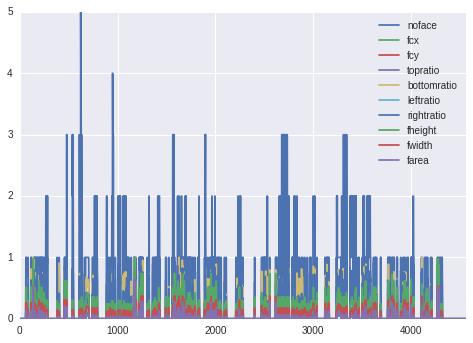

In [16]:
df= getfacedf('Decay')
#df= getfacedf('After_The_Rain')
#df= getfacedf('Attitude_Matters')
#df= getfacedf('Sintel')
t = df #[df['noface']>0][['fcx','fcy']]
plt.figure(figsize=(5,15))
t.plot()

In [21]:
df[df['noface']>1]

noface       fcx       fcy  topratio  bottomratio  leftratio  \
266        2  0.123438  0.061719  0.162500     0.409375   0.868750   
267        2  0.123438  0.061719  0.162500     0.409375   0.093750   
272        2  0.123438  0.061719  0.187500     0.434375   0.756250   
273        2  0.148438  0.074219  0.187500     0.484375   0.726562   
274        2  0.123438  0.061719  0.187500     0.434375   0.743750   
275        2  0.148438  0.074219  0.156250     0.453125   0.742188   
276        2  0.148438  0.074219  0.215625     0.512500   0.126562   
277        2  0.123438  0.061719  0.262500     0.509375   0.193750   
281        2  0.148438  0.074219  0.156250     0.453125   0.742188   
282        2  0.148438  0.074219  0.156250     0.453125   0.742188   
283        2  0.148438  0.074219  0.125000     0.421875   0.742188   
284        2  0.148438  0.061719  0.187500     0.484375   0.876563   
479        3  0.178125  0.089063  0.062500     0.418750   0.620313   
480        3  0.148438  0.074219  0.125000     0.421875   0.621875   
538        3  0.123438  0.061719  0.287500     0.534375   0.593750   
539        2  0.148438  0.074219  0.156250     0.453125   0.637500   
540        2  0.123438  0.061719  0.312500     0.559375   0.206250   
541        2  0.148438  0.074219  0.306250     0.603125   0.562500   
542        3  0.123438  0.061719  0.312500     0.559375   0.556250   
543        3  0.123438  0.061719  0.287500     0.534375   0.556250   
544        2  0.123438  0.061719  0.287500     0.534375   0.181250   
545        2  0.148438  0.074219  0.306250     0.603125   0.576562   
546        2  0.123438  0.061719  0.312500     0.559375   0.568750   
609        2  0.148438  0.074219  0.215625     0.512500   0.546875   
610        3  0.123438  0.061719  0.387500     0.634375   0.293750   
611        2  0.123438  0.061719  0.487500     0.734375   0.018750   
623        5  0.123438  0.061719  0.237500     0.484375   0.543750   
624        4  0.123438  0.061719  0.237500     0.484375   0.593750   
625        4  0.123438  0.061719  0.287500     0.534375   0.531250   
626        4  0.123438  0.061719  0.337500     0.584375   0.518750   
...      ...       ...       ...       ...          ...        ...   
3418       2  0.123438  0.061719  0.112500     0.359375   0.556250   
3428       2  0.123438  0.061719  0.112500     0.359375   0.043750   
3439       2  0.123438  0.061719  0.137500     0.384375   0.068750   
3441       2  0.123438  0.061719  0.387500     0.634375   0.568750   
3513       2  0.178125  0.089063  0.062500     0.418750   0.567187   
3516       2  0.123438  0.061719  0.362500     0.609375   0.393750   
3517       2  0.148438  0.074219  0.337500     0.634375   0.351562   
3521       2  0.148438  0.074219  0.546875     0.843750   0.442188   
3522       2  0.148438  0.074219  0.396875     0.693750   0.412500   
3523       2  0.148438  0.073438  0.515625     0.812500   0.457813   
3524       2  0.148438  0.074219  0.487500     0.784375   0.426563   
3525       2  0.148438  0.074219  0.396875     0.693750   0.426563   
3552       2  0.117188  0.061719  0.000000     0.234375   0.506250   
3561       2  0.148438  0.074219  0.246875     0.543750   0.217188   
3562       2  0.148438  0.074219  0.037500     0.334375   0.142187   
3564       2  0.146875  0.074219  0.278125     0.571875   0.262500   
3565       2  0.146875  0.074219  0.278125     0.571875   0.276562   
3566       2  0.148438  0.074219  0.096875     0.393750   0.201563   
3567       2  0.123438  0.061719  0.062500     0.309375   0.343750   
3568       2  0.123438  0.061719  0.162500     0.409375   0.368750   
3569       2  0.123438  0.061719  0.187500     0.434375   0.368750   
3570       2  0.123438  0.061719  0.112500     0.359375   0.568750   
3579       2  0.123438  0.061719  0.137500     0.384375   0.381250   
3580       2  0.123438  0.061719  0.112500     0.359375   0.543750   
3583       2  0.123438  0.061719  0.162500     0.409375   0.331250   
3584       2  0.

In [22]:
fpsMovie = [['After_The_Rain',23.976],
            ['Attitude_Matters',29.97],
            ['Barely_legal_stories',23.976],
            ['Between_Viewings',25],
            ['Big_Buck_Bunny',24],
            ['Chatter',24],
                ['Cloudland',25],
                ['Damaged_Kung_Fu',25],
                ['Decay',23.976],
                ['Elephant_s_Dream',24],
                ['First_Bite',25],
                ['Full_Service',29.97],
                ['Islands',23.976],
                ['Lesson_Learned',29.97],
                ['Norm',25],
                ['Nuclear_Family',23.976],
                ['On_time',30],
                ['Origami',24],
                ['Parafundit',24],
                ['Payload',25],
                ['Riding_The_Rails',23.976],
                ['Sintel',24],
                ['Spaceman',23.976],
                ['Superhero',29.97],
                ['Tears_of_Steel',24],
                ['The_room_of_franz_kafka',29.786],
                ['The_secret_number',23.976],
                ['To_Claire_From_Sonny',23.976],
                ['Wanted',25],
                ['You_Again',29.97]]

contmoviesfps = pd.DataFrame(fpsMovie,columns=['name','fps'])
contmoviesfps.set_index('name', inplace=True)
contmoviesfps.index.name = None
#contmoviesfps['After_The_Rain']
contmoviesfps['f'] = np.round(contmoviesfps['fps'])


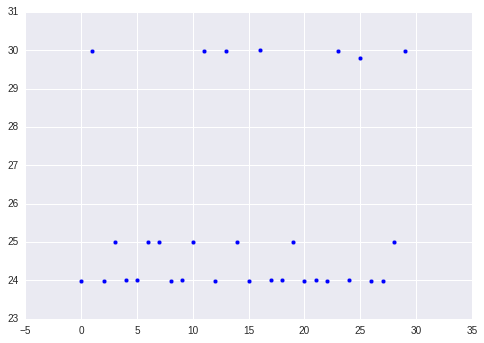

In [23]:
plt.scatter(range(contmoviesfps.shape[0]), contmoviesfps['fps'])
#contmoviesfps.plot()

In [24]:
def getfps(movname):
    return contmoviesfps.loc[movname ]['f']

In [25]:
print contmoviesfps[ contmoviesfps.index == 'You_Again' ]['f']
print getfps('You_Again')

You_Again    30.0
Name: f, dtype: float64
30.0


In [26]:
movgroups_wodecay = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload']
}

movgroups = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    5:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
    6:['Decay']
}

mov2groups = {
    0:['Decay'],
    1:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    2:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    3:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    4:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    5:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    6:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload'],
}


def gettraintestmovielist(mlist,groups=movgroups):
    testlist = groups[mlist]
    trainlist =[]
    for idx, group in enumerate(groups):
        if idx != mlist:
            for g in groups[idx]:
                trainlist.append(g)
    return trainlist, testlist

''' 
def gettraintest2movielist(foldno,groups=mov2groups):
    if foldno==1:
        mlist=[1,2]
    elif foldno==2:
        mlist=[3,4]
    elif foldno==3:
        mlist=[5,6]
    elif foldno==4:
        mlist=[2,3]
    elif foldno==5:
        mlist=[4,5]
    else:
        mlist=[]
    
    testlist = [] 
    for i in mlist:
        for f in groups[i]:
            testlist.append(f)
            
    trainlist =[]
    for idx, group in enumerate(groups):
        for f in groups[idx]:
            if f not in testlist:
                trainlist.append(f)
                
    return trainlist, testlist
'''

' \ndef gettraintest2movielist(foldno,groups=mov2groups):\n    if foldno==1:\n        mlist=[1,2]\n    elif foldno==2:\n        mlist=[3,4]\n    elif foldno==3:\n        mlist=[5,6]\n    elif foldno==4:\n        mlist=[2,3]\n    elif foldno==5:\n        mlist=[4,5]\n    else:\n        mlist=[]\n    \n    testlist = [] \n    for i in mlist:\n        for f in groups[i]:\n            testlist.append(f)\n            \n    trainlist =[]\n    for idx, group in enumerate(groups):\n        for f in groups[idx]:\n            if f not in testlist:\n                trainlist.append(f)\n                \n    return trainlist, testlist\n'

In [27]:
gettraintestmovielist(2)


(['You_Again',
  'Damaged_Kung_Fu',
  'The_secret_number',
  'Spaceman',
  'Cloudland',
  'Origami',
  'Riding_The_Rails',
  'Tears_of_Steel',
  'Sintel',
  'Islands',
  'To_Claire_From_Sonny',
  'Nuclear_Family',
  'After_The_Rain',
  'Parafundit',
  'The_room_of_franz_kafka',
  'Attitude_Matters',
  'Lesson_Learned',
  'Superhero',
  'First_Bite',
  'Wanted',
  'Between_Viewings',
  'Barely_legal_stories',
  'Payload',
  'Decay'],
 ['On_time',
  'Elephant_s_Dream',
  'Norm',
  'Big_Buck_Bunny',
  'Chatter',
  'Full_Service'])

## Fear Annotations

In [28]:
def getFearDf(movname):
    filename = os.path.join(med2017fearFolder, movname + '-MEDIAEVAL2017-fear.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df


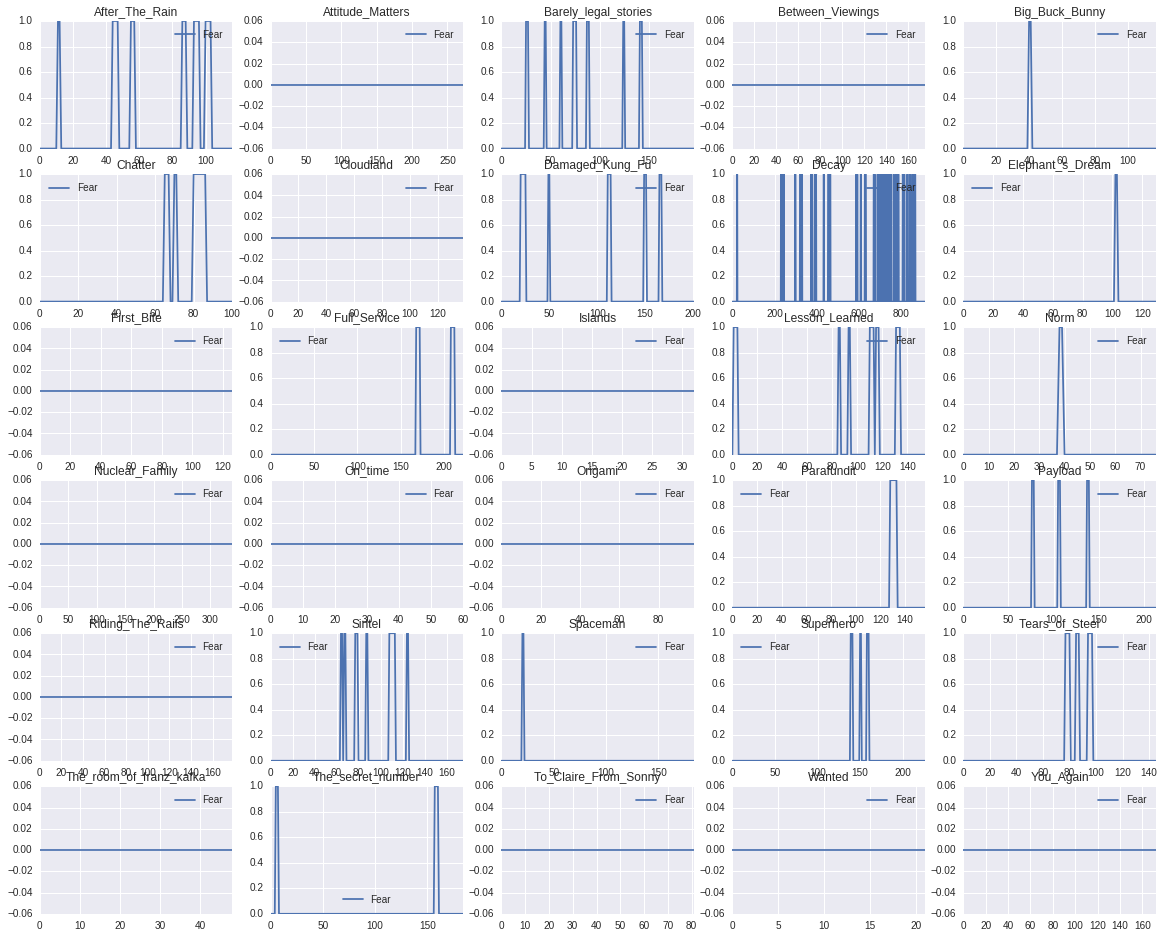

In [29]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),title=mov)

## Valence Arousal Annotations

In [30]:
def getAnnotationDf(movname,folder=med2017annotationsFolder):
    filename = os.path.join(folder, movname + '-MEDIAEVAL2017-valence_arousal.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df

In [31]:
def getAnnotationDf(movname,folder=med2017annotationsFolder):
    filename = os.path.join(folder, movname + '-MEDIAEVAL2017-valence_arousal.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df

In [32]:
df = getAnnotationDf(movieNames[0])
#df.hist(alpha=0.5,bins=50)
df.head()

Id  Time  MeanValence  MeanArousal
0   0     0    -0.000787    -0.162383
1   1     5    -0.000837    -0.184550
2   2    10    -0.000837    -0.205490
3   3    15    -0.000390    -0.207942
4   4    20     0.007565    -0.192212

In [33]:
#df.head()
#df.describe()
df = getAnnotationDf('Islands')
df.head(2)

Id  Time  MeanValence  MeanArousal
0   0     0     0.098658    -0.098712
1   1     5     0.137632    -0.108957

In [34]:
#df = getAnnotationDf(movieNames[0])
#df.hist(alpha=0.5,bins=50)#df.head()
#df.describe()
#df = getAnnotationDf('Islands')
#df.head()

## Visualize 

In [112]:
def avfear(mov = 'Sintel'):
    plt.figure(figsize=(10,8))
    plt.axis([-1, 1500, -1, 1])
    avdf = getAnnotationDf(mov)
    avdf[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='-',title=mov)
    feardf = getFearDf(mov)
    feardf[['Fear']].plot(ax=plt.gca(),title=mov,style='-')

In [122]:
#avfear('Islands')

In [114]:
fdf= getFearDf('Islands')
len(fdf[fdf['Fear']>0])

0

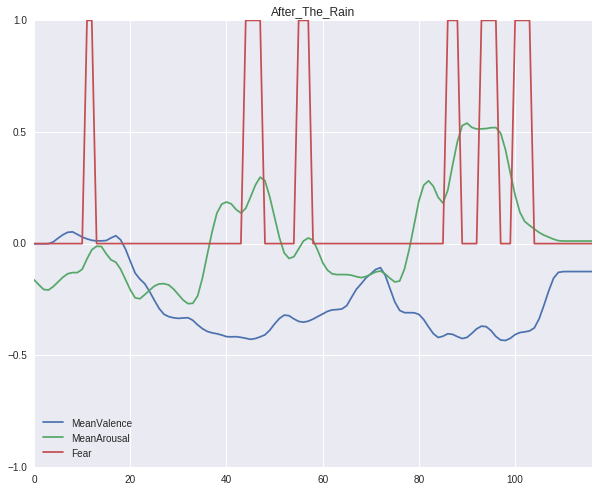

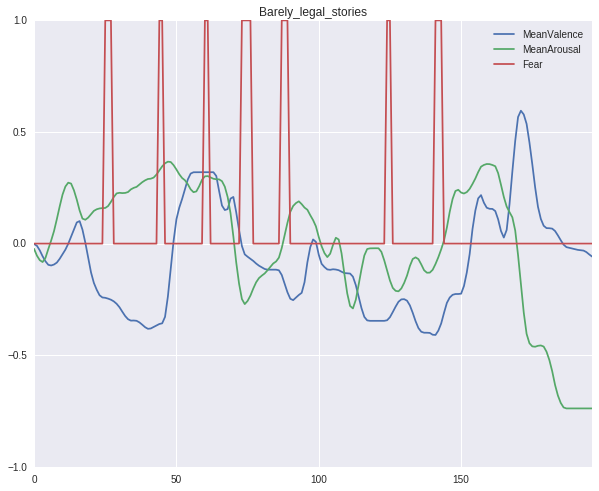

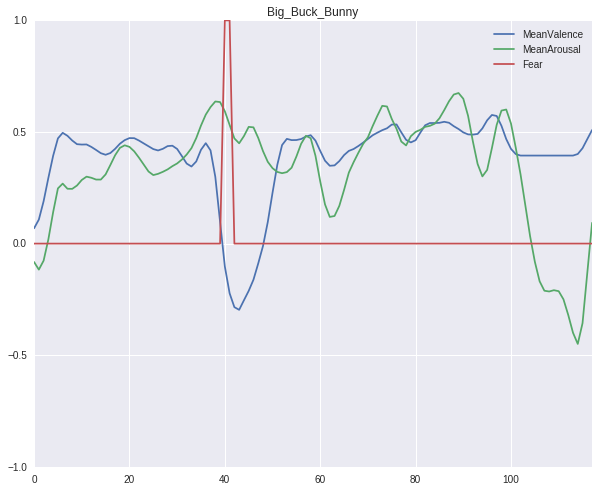

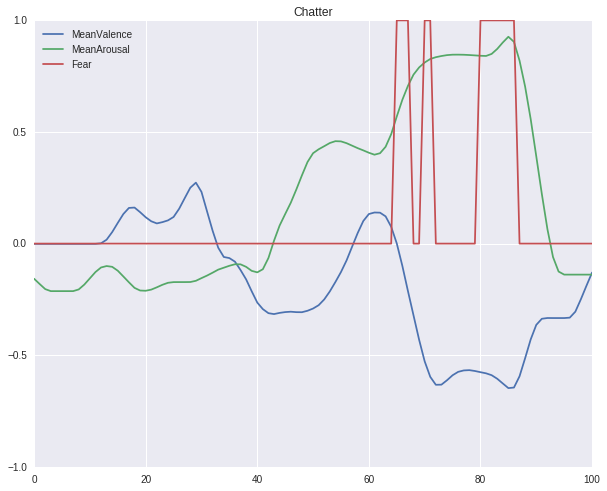

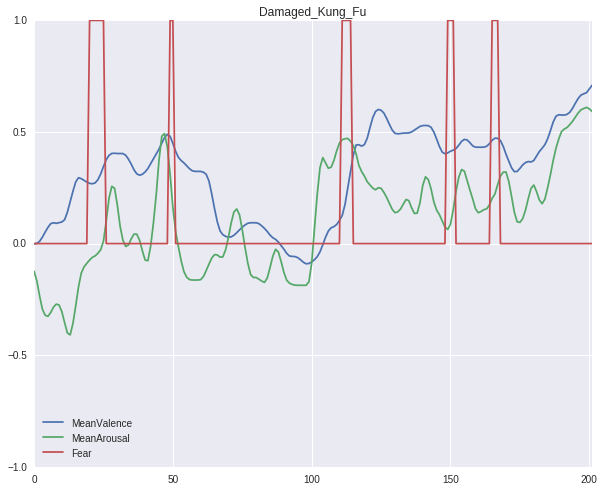

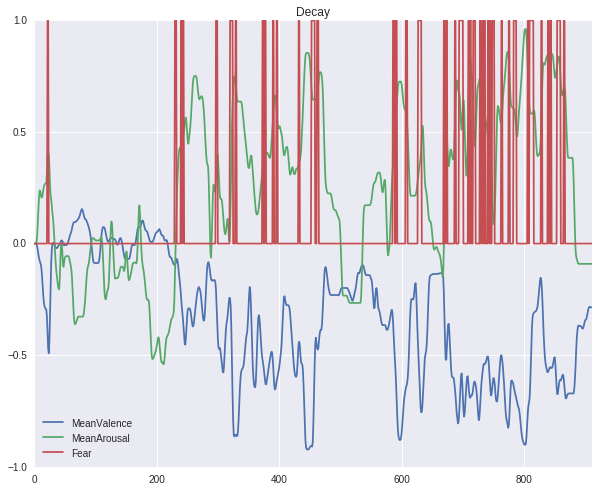

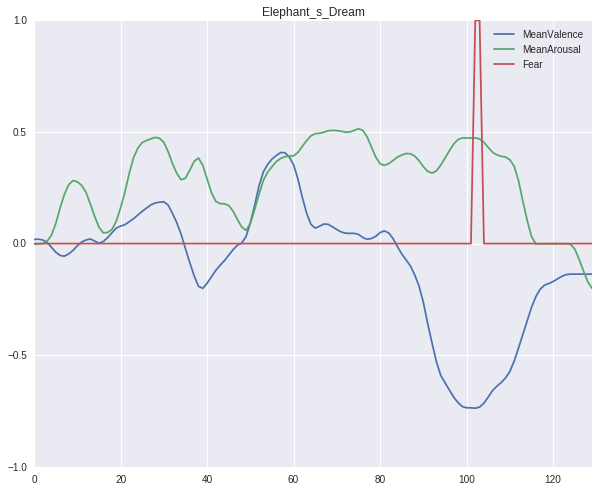

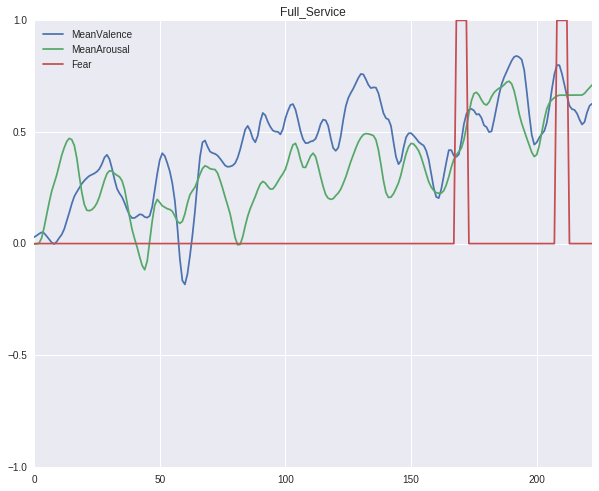

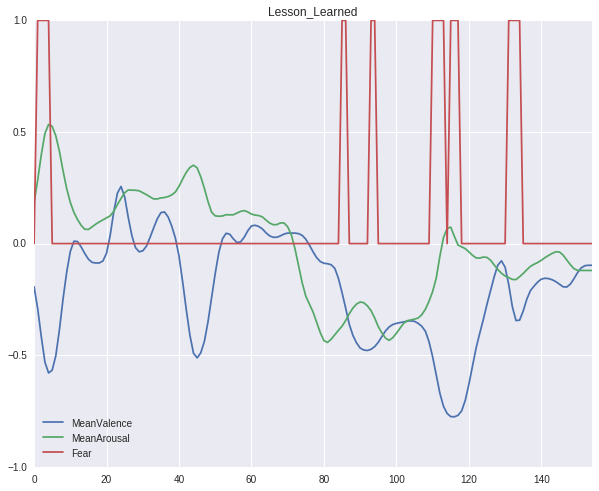

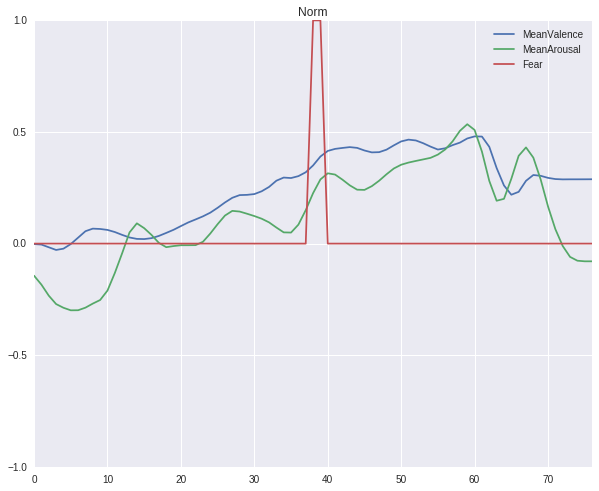

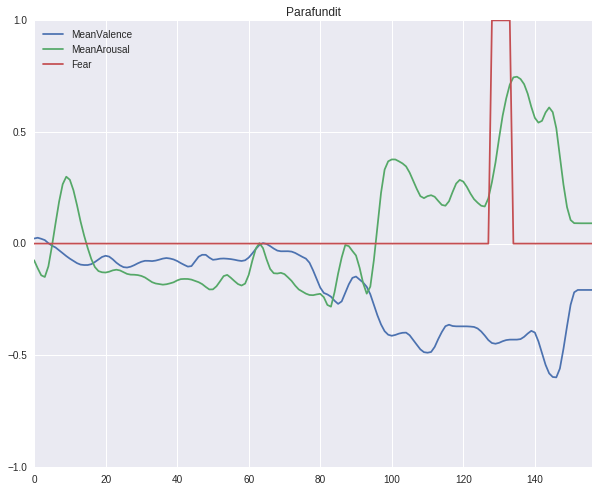

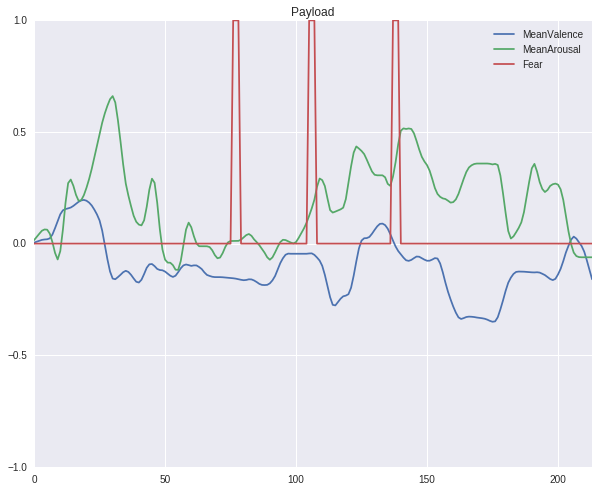

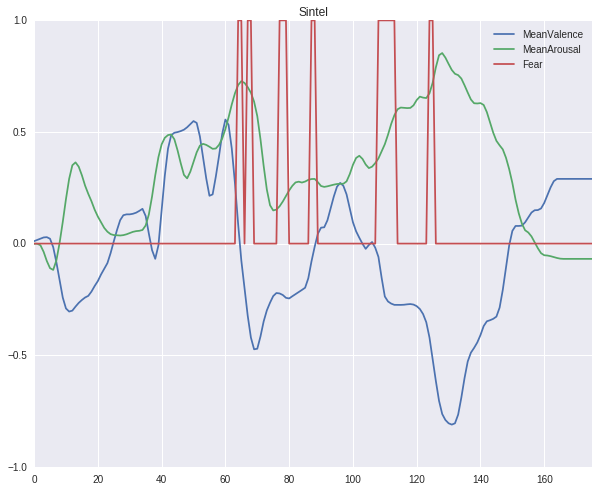

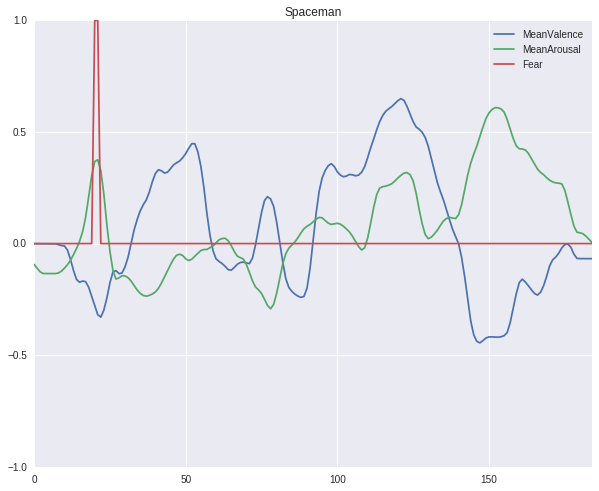

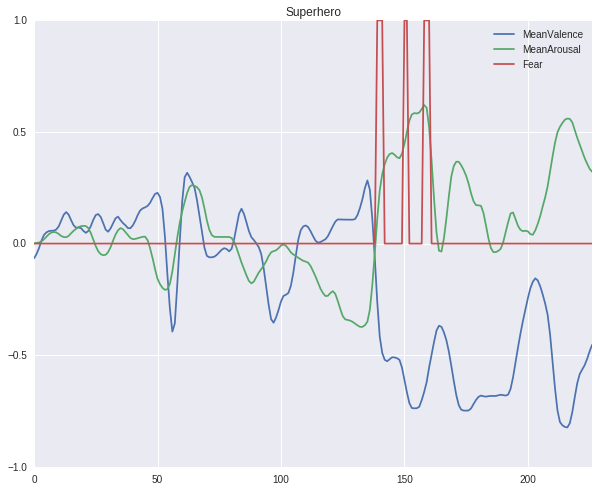

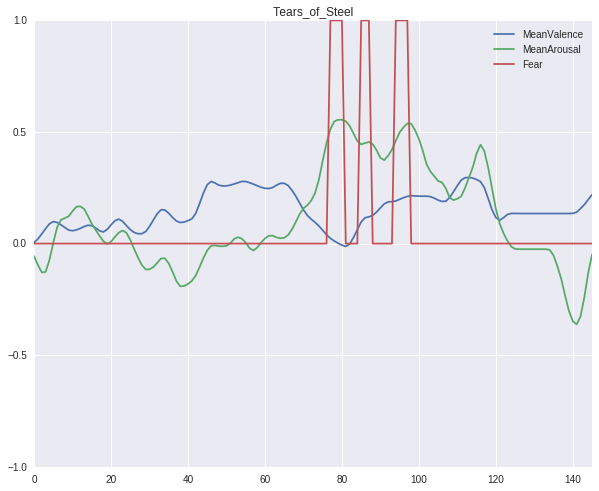

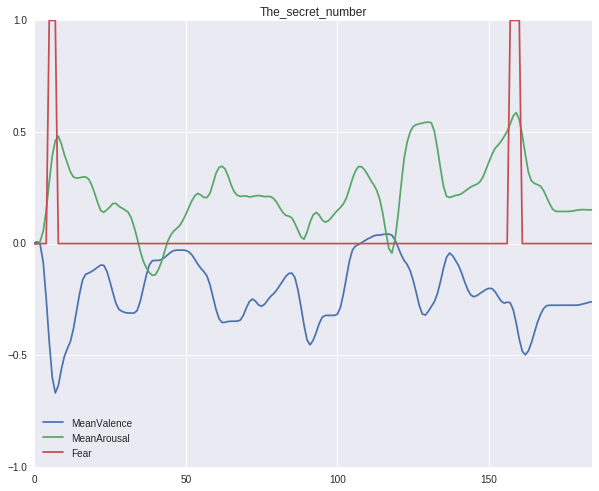

In [115]:
fearfull = []
for i in movieNames:
    fdf = getFearDf(i)
    if len(fdf[fdf['Fear'] == 1 ]) > 0:
        fearfull.append(i)

len(fearfull)

for i in fearfull:
    avfear(i)

# Shot boundary detections

In [116]:
def getShotDf(movie,folder=pathcontfeatures):
    filename =  folder + movie + '.mp4-shot-times.txt'
    shotarray = np.genfromtxt(filename, delimiter=' ',dtype=int)
    df = pd.DataFrame(shotarray,columns=['cut'])
    fps=getfps(movie)
    #fps
    df['time'] = df['cut']*1. / fps
    return df

In [117]:
x = getShotDf('Sintel')['time']
df = getAnnotationDf('Sintel')
getfps('Sintel')

24.0

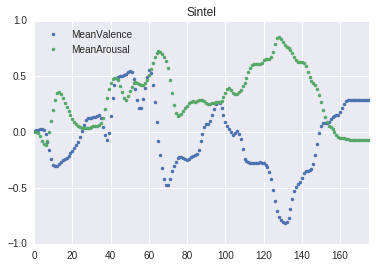

In [118]:
movname = 'Sintel'
df = getAnnotationDf(movname)
df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=movname)


In [119]:
len(x),df.shape

(227, (176, 4))

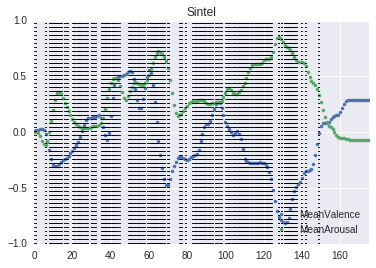

In [120]:
#plt.scatter(x,np.ones(len(x)))
movname = 'Sintel'
df = getAnnotationDf(movname)
df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=movname)
cuts = getShotDf(movname)['time']
for i in range(len(cuts)):
    x=cuts[i]/5
    plt.axvline(x,linestyle=':',color='black')

#plt.title('AV plor with shot times')
#plt.tight_layout()

In [51]:
#df.head(10)
#cuts.head()

In [52]:
#tin = pd.DataFrame(np.arange(100),columns=['Id'])
#tin['Time'] = tin['Id']*5
#tin.head(10), 
#tin.rolling(window=10).mean()[8:]
#tin.head(15)
#ten seconds-segments sliding over the whole movie with a shift of 5 seconds

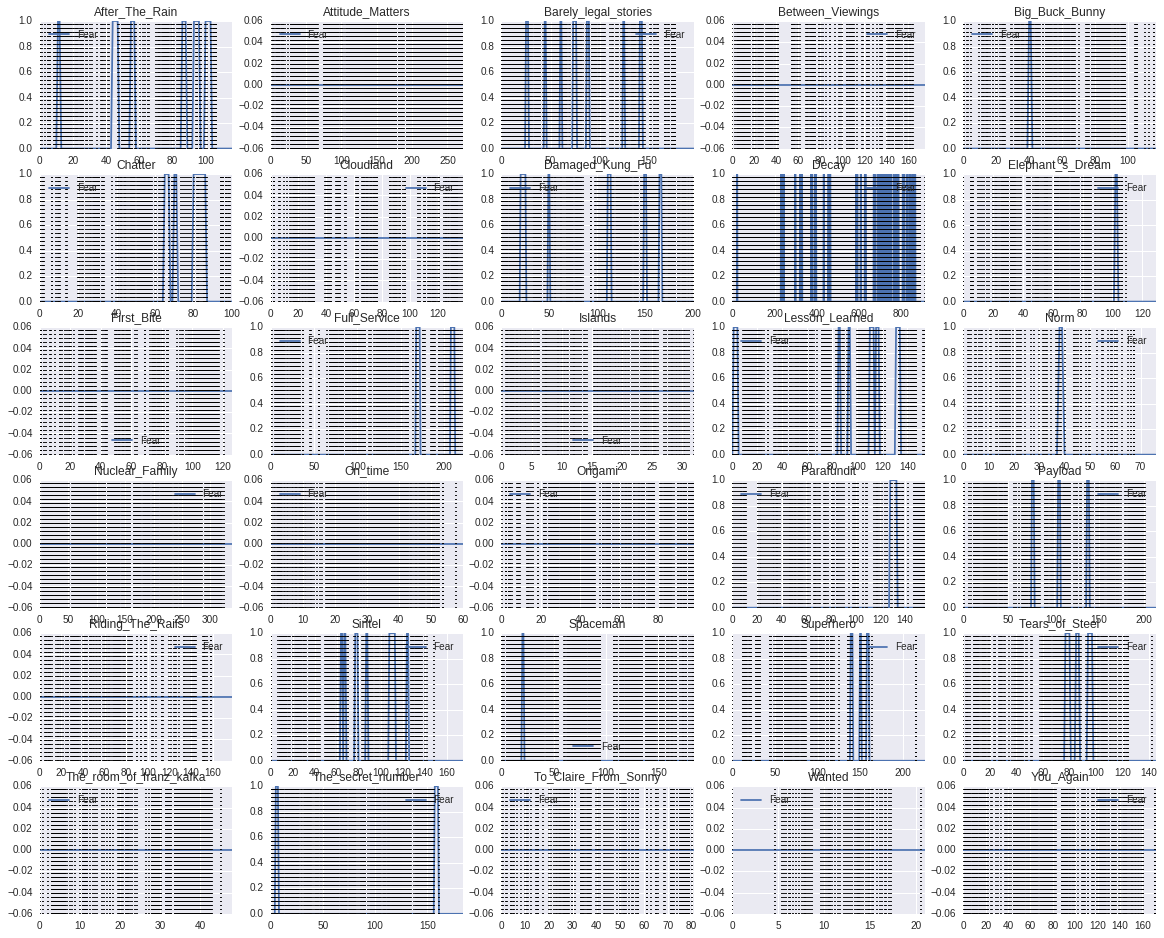

In [121]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),title=mov)
    cuts = getShotDf(mov)['time']
    for i in range(len(cuts)):
        x=cuts[i]/5   ## conversion of time to sliding windows with 5 
        plt.axvline(x,linestyle=':',color='black')


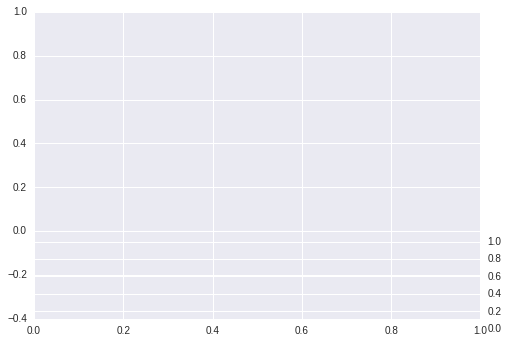

In [57]:
# lets now take a look and see if its doing something sensible
import matplotlib
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots(1,1)
#ax1.plot(data['Close'])
y = ax1.get_ylim()
ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

ax2 = ax1.twinx()
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))
#ax2.plot(data['Buy'], color='#77dd77')
#ax2.plot(data['Sell'], color='#dd4444')

## Valence, Arousal histogram plots for Dev-Set

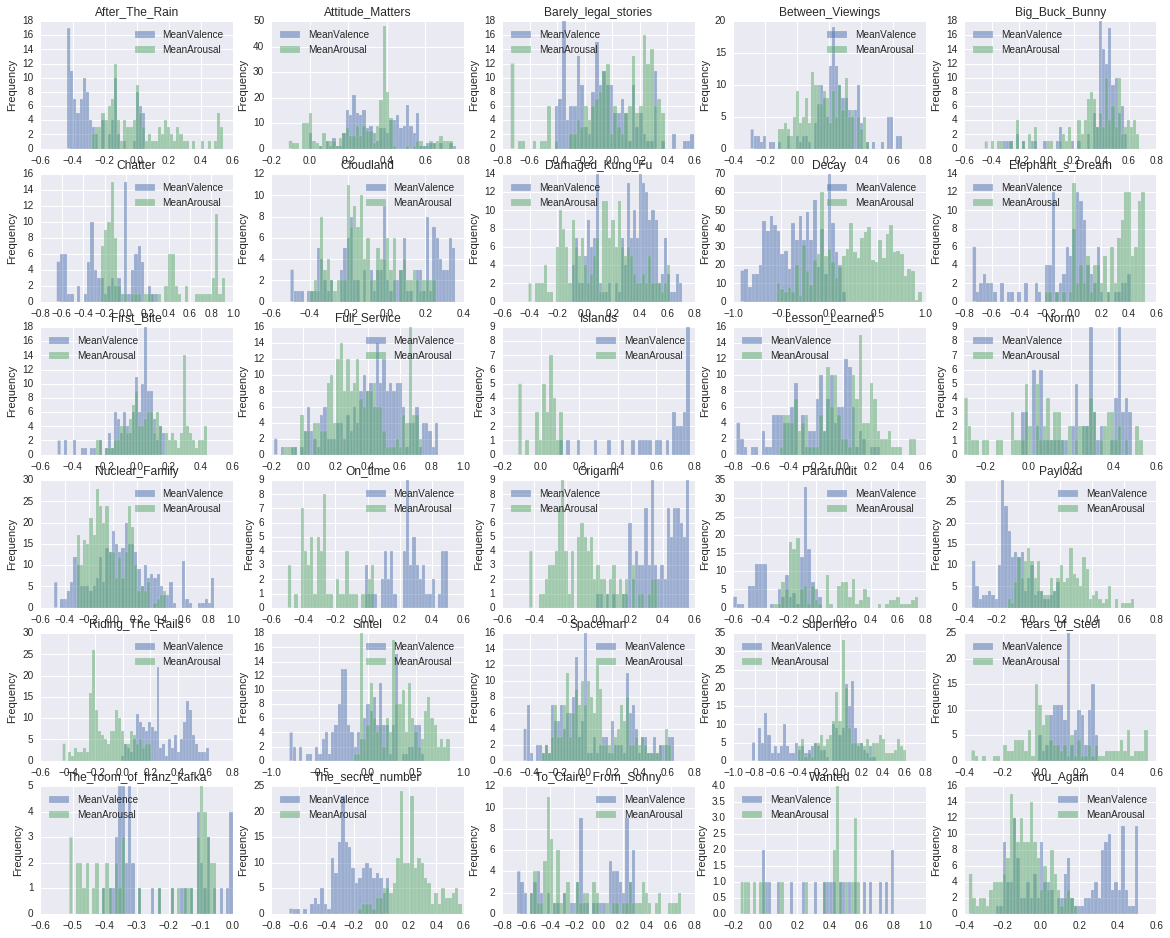

In [58]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)    
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot.hist(ax=plt.gca(),title=mov,alpha=0.5,bins=50)

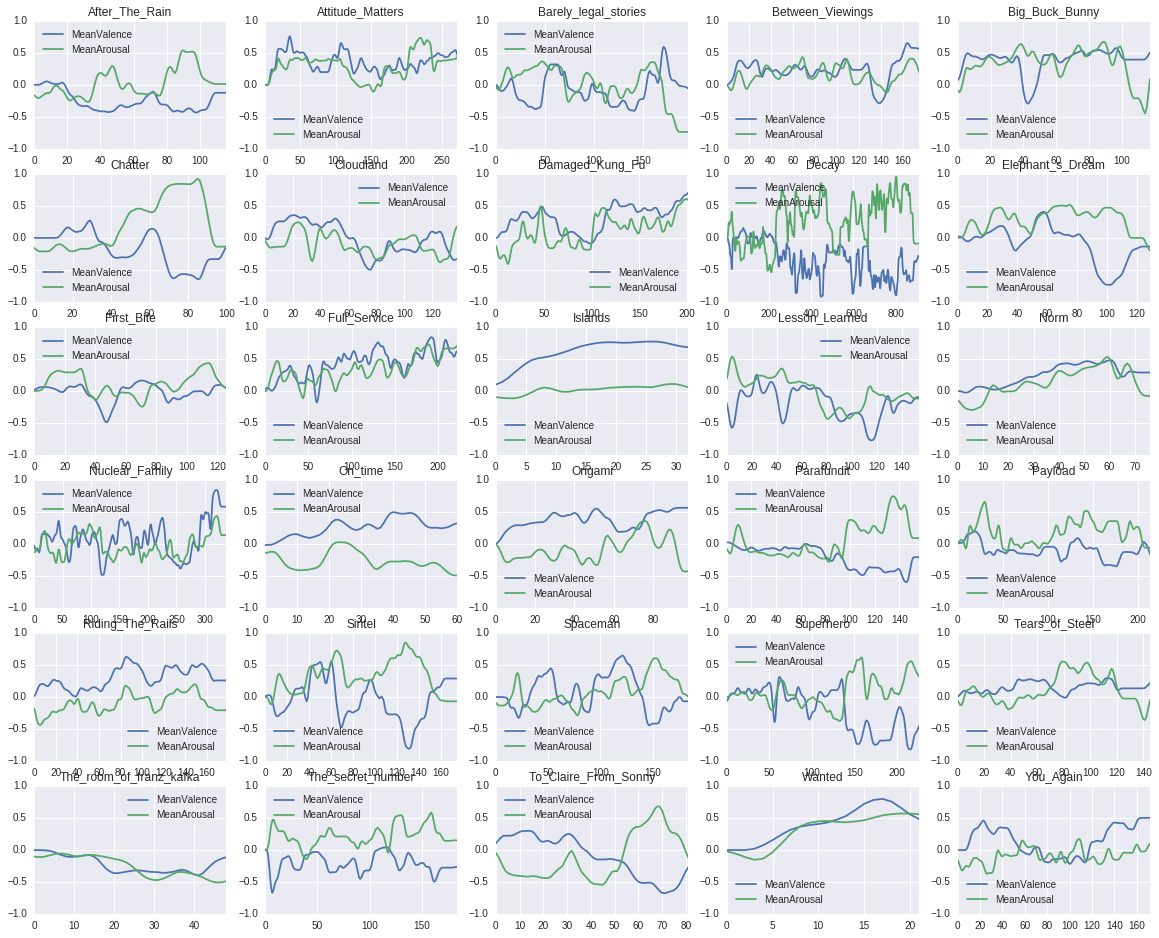

In [59]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([-1, 1500, -1, 1])
    dfa = getAnnotationDf(mov)
    dfa[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)


## Valence , Arousal plots for Dev-Set

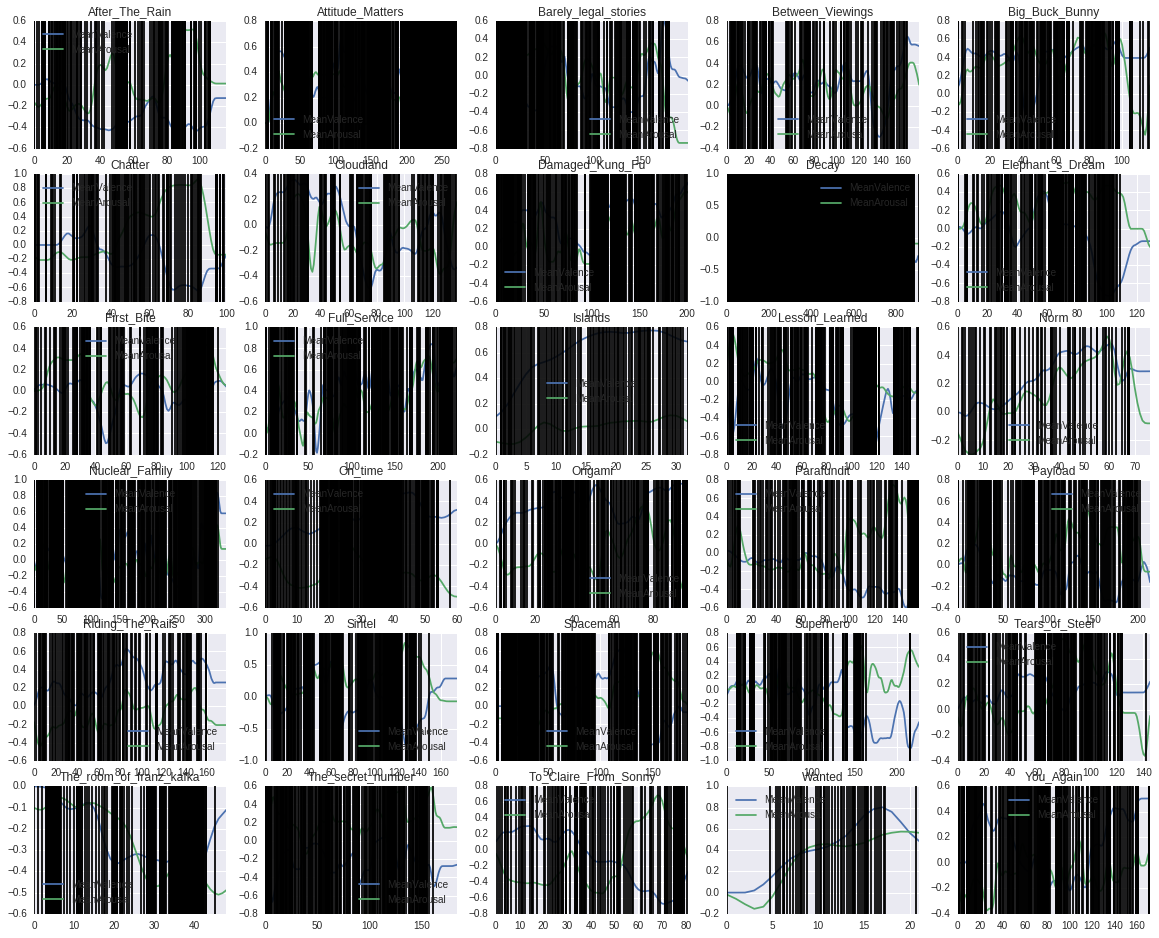

In [60]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    cuts = getShotDf(mov)['time']
    for i in range(len(cuts)):
        x=cuts[i]/5
        plt.axvline(x,linestyle='-',color='black')

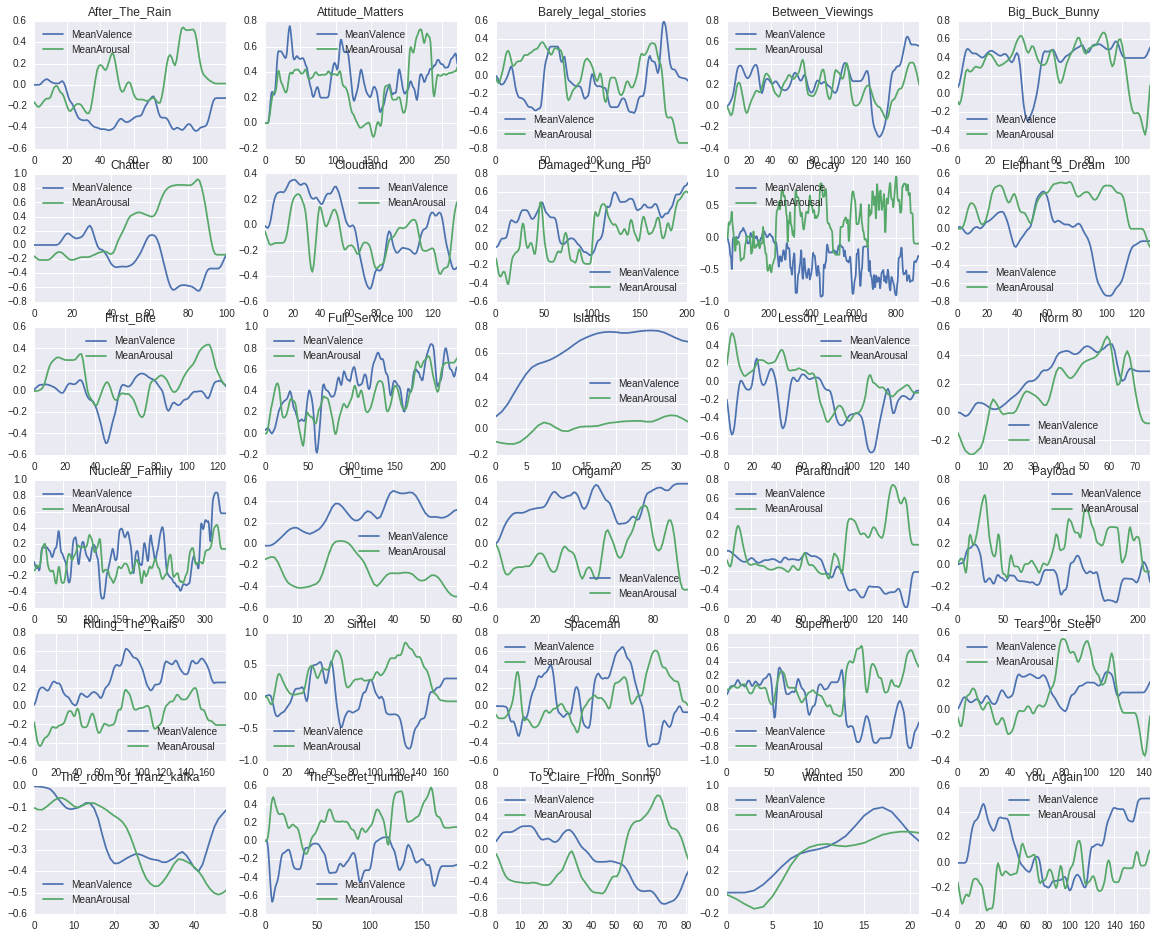

In [61]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getAnnotationDf(mov)
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),title=mov)
    #.hist(alpha=0.5,bins=50)


## Audio Features


In [62]:
def getAudioDf(moviename,folder=med2017audiofolder):
    if 'TestSet' in folder:
        files = glob.glob(folder+moviename+'/audio_features/*.csv')
    else:
        files = glob.glob(folder+moviename+'/*.csv')
    files = sorted(files)
    files
    alist = []
    for fname in files:
        f=open(fname,'r')
        h = []
        for l in f :
            if '@attribute' in l:
                h.append(l.split()[1])
            elif l == '\n':
                l
            elif l[0] =='@':
                l
            else:
                alist.append(map(float,l.split(',')[1:])) #first attribute is string ,skipped
        f.close()
    
    return pd.DataFrame(alist,columns=h[1:])

## Visual Features

In [63]:
visual_feat = ['acc', 'cedd', 'cl', 'eh', 'fc6', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]
visual_feat_wofc16 = ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [66]:
def getVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    files = glob.glob(folder+moviename+'/'+typename+'/*.txt')
    files = sorted(files)
    alist = []
    for fname in files:
        f=open(fname,'r')
        for l in f:
            alist.append(map(float,l.split(',')))
        f.close()
    return pd.DataFrame(alist)

def getAvgVisFeatureDf(moviename,typename,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,typename,folder)
    dfwindow = df.rolling(10).mean()[9::5] ############### start with 9
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

def getAvgVisFeatListDf(moviename,featlist,folder=med2017visualFeaturesfolder):
    df = getVisFeatureDf(moviename,featlist[0],folder)
    for feat in featlist[1:]:
        tdf = getVisFeatureDf(moviename,feat,folder)
        df = pd.concat([df,tdf],axis=1)
    
    dfwindow = df.rolling(10).mean()[9::5] ############### start with 9
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.columns=list(range(len(dfwindow.columns)))
    return dfwindow

In [67]:
sum([len(getAnnotationDf(m)) for m in movieNames ])

5274

In [68]:
sum([len(getAudioDf(m)) for m in movieNames ])

5264

In [69]:
sum([len(getVisFeatureDf(m,'cl')) for m in movieNames ])

26589

In [70]:
sum([len(getAvgVisFeatureDf(m,'cl')) for m in movieNames ])

5276

In [71]:
df = getVisFeatureDf(movieNames[0],'cl')
#df = getAvgVisFeatureDf(movieNames[0],'cl')
#df = getAvgVisFeatListDf(movieNames[0],['cl','eh'])
#df.hist()
df.head(10)

0     1     2     3     4     5     6     7     8     9   ...     23  \
0   2.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0  ...   16.0   
1   2.0  15.0  15.0  16.0  16.0  16.0  15.0  15.0  15.0  16.0  ...   16.0   
2  15.0  16.0  14.0  14.0  16.0  16.0  16.0  15.0  16.0  15.0  ...   16.0   
3   6.0  17.0  15.0   8.0  16.0  12.0  18.0  16.0  16.0  16.0  ...   15.0   
4   3.0  16.0  15.0  11.0  16.0  12.0  16.0  16.0  15.0  16.0  ...   16.0   
5   4.0  14.0  16.0  13.0  15.0  13.0  16.0  15.0  16.0  15.0  ...   15.0   
6   3.0  14.0  16.0  13.0  15.0  12.0  16.0  15.0  16.0  15.0  ...   16.0   
7   4.0  14.0  16.0  13.0  15.0  12.0  16.0  15.0  16.0  15.0  ...   16.0   
8   4.0  14.0  16.0  13.0  15.0  12.0  16.0  15.0  16.0  15.0  ...   16.0   
9   3.0  15.0  16.0  13.0  15.0  12.0  16.0  15.0  16.0  15.0  ...   16.0   

     24    25    26    27    28    29    30    31    32  
0  16.0  16.0  16.0  32.0  16.0  16.0  16.0  16.0  16.0  
1  16.0  16.0  16.0  31.0  16.0  16.0  16.0  16.0  16.0  
2  15.0  16.0  16.0  21.0  15.0  16.0  16.0  16.0  16.0  
3  15.0  16.0  15.0  27.0  15.0  16.0  17.0  15.0  17.0  
4  15.0  16.0  15.0  30.0  16.0  16.0  17.0  16.0  16.0  
5  16.0  15.0  15.0  29.0  16.0  16.0  16.0  16.0  16.0  
6  16.0  16.0  16.0  31.0  16.0  16.0  16.0  16.0  16.0  
7  16.0  16.0  16.0  31.0  16.0  16.0  16.0  16.0  16.0  
8  16.0  16.0  16.0  31.0  16.0  16.0  16.0  16.0  16.0  
9  16.0  16.0  16.0  31.0  16.0  16.0  16.0  16.0  16.0  

[10 rows x 33 columns]

In [72]:
#df = getAvgVisFeatListDf(movieNames[0],['fc6'])
#df = getVisFeatureDf(movieNames[0],'fc6')
#df.describe()

## Low Level Cinematographic Features
fps değerlerine göre, feature çıkarma key frame seçme ve averaging tekrar yapılacak.

In [73]:
def getLowFeatureDf(movname,folder=pathcontfeatures):
    fname = movname +'.mp4continous_features.txt'
    
    df = pd.DataFrame(np.genfromtxt( os.path.join(folder,fname)))
    df.columns = ['time','framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']
    return df

def getLowFeature10SecDf(movname):
    pdf = getLowFeatureDf(movname)
    
    dfwindow = pdf.rolling(10).mean()[9::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.drop('time',axis=1,inplace=True)
    return dfwindow

def getMovieListLowFeatFearDf(movieNames):
    X = getLowFeature10SecDf(movieNames[0])
    y = getFearDf(movieNames[0]).Fear[:len(X)]

    for mov in movieNames[1:]:
        tX=getLowFeatureDf(mov)
        ty=getFearDf(mov).Fear[:len(tX)]
        X = X.append(tX)
        y = y.append(ty)
        if (X.shape != y.shape):
            print mov, X.shape, y.shape
    return X,y

In [74]:
#getLowFeatureDf(movieNames[1]).head(10)[2::2]

In [75]:
#print getLowFeatureDf(movieNames[1]).head(10)
#print getLowFeatureDf(movieNames[1]).head(10).mean()
print getLowFeature10SecDf(movieNames[1]).head(10)

   framemean    huemean     satmean     valmean    redmean  greenmean  \
0       11.0  16.266390  108.533860   24.615390   5.417613   5.983095   
1        9.5  10.111689   65.248124   15.309475   7.196943   7.676144   
2       14.1   7.779963   10.971608   15.279160  14.210921  14.116898   
3       54.6  31.491614   36.296284   59.702565  52.819005  54.486605   
4       79.8  47.335400   74.969860   89.290460  75.284470  79.210160   
5       70.7  46.443380   82.062840   80.176950  66.029620  69.923720   
6       73.1  49.213990   78.506800   82.417040  69.214910  72.537860   
7       75.4  45.503130   70.678890   83.767210  70.378780  75.304340   
8       79.0  31.727480   83.240130   92.335810  65.965150  76.843300   
9       84.5  24.291420  101.637440  103.255080  66.305130  79.824300   

     bluemean  lummean     motion  
0   24.605360      0.7  26.035474  
1   15.304023      0.1   4.688359  
2   14.986898      6.0  10.187818  
3   57.096935     50.0  15.618866  
4   84.692030   

## Face Features 

In [76]:
def getFaceFeature(movie):
    df  = getfacedf(movie)
    dfwindow = df.rolling(window=10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

In [77]:
getFaceFeature('Islands').head()

noface           fcx       fcy  topratio  bottomratio  leftratio  \
0     0.0  0.000000e+00  0.000000  0.000000     0.000000   0.000000   
1     0.2  1.939815e-02  0.010937  0.086667     0.125463   0.065937   
2     0.2  1.939815e-02  0.010937  0.086667     0.125463   0.065937   
3     0.0  1.387779e-18  0.000000  0.000000     0.000000   0.000000   
4     0.0  1.387779e-18  0.000000  0.000000     0.000000   0.000000   

   rightratio       fheight    fwidth     farea  
0    0.000000  0.000000e+00  0.000000  0.000000  
1    0.087813  3.879630e-02  0.021875  0.004761  
2    0.087813  3.879630e-02  0.021875  0.004761  
3    0.000000  2.775558e-18  0.000000  0.000000  
4    0.000000  2.775558e-18  0.000000  0.000000

## Train and Test set creation

In [78]:
def getFeatureswFearDf(movie,featlist=visual_feat_wofc16):
    Xv = getAvgVisFeatListDf(movie,featlist)
    Xa = getAudioDf(movie)
    Xd = getAvgVisFeatListDf(movie,['fc6'])
    Xl = getLowFeature10SecDf(movie)
    Xf = getFaceFeature(movie)
    y = getFearDf(movie)[['Fear']]

    return Xv,Xa,Xd,Xl,Xf,y

In [79]:
Xv,Xa,Xd,Xl,Xf,y = getFeatureswFearDf('Attitude_Matters')

In [80]:
#lambda a: print(a.shape) for a in [Xv,Xa,Xd,Xd,Xl,Xf,y]
Xv.shape,Xa.shape,Xd.shape,Xd.shape,Xl.shape,Xf.shape,y.shape

((273, 1271),
 (273, 1583),
 (273, 4096),
 (273, 4096),
 (282, 9),
 (273, 10),
 (273, 1))

In [81]:
def getFeatureswFearDf(movieNames,featlist=visual_feat_wofc16):
    Xv = getAvgVisFeatListDf(movieNames[0],featlist)
    Xa = getAudioDf(movieNames[0])
    Xd = getAvgVisFeatListDf(movieNames[0],['fc6'])
    Xl = getLowFeature10SecDf(movieNames[0])
    Xf = getFaceFeature(movieNames[0])
    y = getFearDf(movieNames[0])[['Fear']]
    
    mlen = min(len(Xv),len(Xa), len(Xd), len(Xl),len(Xf),len(y))
    
    Xv = Xv[:mlen]
    Xa = Xa[:mlen]
    Xd = Xd[:mlen]
    Xl = Xl[:mlen]
    Xf = Xf[:mlen]
    y  = y[:mlen]
    
    for mov in movieNames[1:]:
        tXv = getAvgVisFeatListDf(mov,featlist)
        tXa = getAudioDf(mov)
        tXd = getAvgVisFeatListDf(mov,['fc6'])
        tXl = getLowFeature10SecDf(mov)
        tXf = getFaceFeature(mov)
        ty = getFearDf(mov)[['Fear']]
        
        mlen = min(len(tXv),len(tXa),len(tXd),len(tXl),len(tXf),len(ty))
        tXv = tXv[:mlen]
        tXa = tXa[:mlen]
        tXd = tXd[:mlen]
        tXl = tXl[:mlen]
        tXf = tXf[:mlen] 
        ty = ty[:mlen]
        
        Xv  = Xv.append(tXv)
        Xa  = Xa.append(tXa)
        Xd = Xd.append(tXd)
        Xl = Xl.append(tXl)
        Xf = Xf.append(tXf)
        y  = y.append(ty)
        
    return Xv,Xa,Xd,Xl,Xf,y

In [82]:
def df2mat(df):
    return df.as_matrix().reshape((len(df),))


# Classification work

In [83]:
import sklearn
sklearn.__version__

'0.19.1'

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#from sklearn.grid_search import GridSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from sklearn import cross_validation
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams


In [85]:
def getGridCV(pipe,paramgirid,Xtrain,ytrain): # scoring ?
    grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=125)
    grid.fit(Xtrain,ytrain)
    
    return grid


In [86]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
              (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Train and Test set selection in development set

In [87]:
trainlist, testlist=gettraintestmovielist(2,mov2groups) # index 2 olanları test , diğerlerini train yapan fonksiyon
trainlist,testlist

(['Decay',
  'You_Again',
  'Damaged_Kung_Fu',
  'The_secret_number',
  'Spaceman',
  'On_time',
  'Elephant_s_Dream',
  'Norm',
  'Big_Buck_Bunny',
  'Chatter',
  'Full_Service',
  'Islands',
  'To_Claire_From_Sonny',
  'Nuclear_Family',
  'After_The_Rain',
  'Parafundit',
  'The_room_of_franz_kafka',
  'Attitude_Matters',
  'Lesson_Learned',
  'Superhero',
  'First_Bite',
  'Wanted',
  'Between_Viewings',
  'Barely_legal_stories',
  'Payload'],
 ['Cloudland', 'Origami', 'Riding_The_Rails', 'Tears_of_Steel', 'Sintel'])

In [88]:
tXv,tXa,tXd,tXl,tXf,ty = getFeatureswFearDf(trainlist)
print(tXv.shape,tXa.shape,tXd.shape,tXl.shape,ty.shape)

((4526, 1271), (4526, 1583), (4526, 4096), (4526, 9), (4526, 1))


In [89]:
testXv, testXa, testXd,testXl, testXf, testy = getFeatureswFearDf(testlist)
print(testXv.shape, testXa.shape,testXd.shape, testXl.shape, testy.shape)

((738, 1271), (738, 1583), (738, 4096), (738, 9), (738, 1))


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# Grid-Search cross validation Logistic Regression

In [91]:
%%time

pipe = make_pipeline(LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid_visual = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_visual.fit(tXv, ty)

grid_audio = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_audio.fit(tXa, ty)


/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

CPU times: user 15.2 s, sys: 424 ms, total: 15.6 s
Wall time: 6min 22s


In [92]:
print("Best cross-validation score: {:.2f}".format(grid_visual.best_score_))
print("Best parameters: ", grid_visual.best_params_)

print("Best cross-validation score: {:.2f}".format(grid_audio.best_score_))
print("Best parameters: ", grid_audio.best_params_)


Best cross-validation score: 0.82
('Best parameters: ', {'logisticregression__C': 0.001})
Best cross-validation score: 0.91
('Best parameters: ', {'logisticregression__C': 0.001})


Deep Neural Network feature fc6 produces the hiest recall rate with logistic regression classifier

In [93]:
predictionsv = LogisticRegression(C=0.001).fit(tXv, ty).predict(testXv)
predictionsa = LogisticRegression(C=0.001).fit(tXa, ty).predict(testXa)
predictionsd = LogisticRegression(C=0.001).fit(tXd, ty).predict(testXd)
predictionsl = LogisticRegression(C=0.001).fit(tXl, ty).predict(testXl)
predictionsf = LogisticRegression(C=0.001).fit(tXf, ty).predict(testXf)

print('Visual Features:\n {}\n'.format(metrics.classification_report(predictionsv,testy)))
print('Audio:\n {}\n'.format(metrics.classification_report(predictionsa,testy))) 
print('Deep:\n {}\n'.format(metrics.classification_report(predictionsd,testy)))
print('Low Level:\n {}\n'.format(metrics.classification_report(predictionsl,testy))) 
print('Face:\n {}\n'.format(metrics.classification_report(predictionsf,testy))) 

Visual Features:
              precision    recall  f1-score   support

          0       0.99      0.96      0.98       733
          1       0.00      0.00      0.00         5

avg / total       0.99      0.96      0.97       738


Audio:
              precision    recall  f1-score   support

          0       1.00      0.96      0.98       736
          1       0.00      0.00      0.00         2

avg / total       0.99      0.96      0.98       738


Deep:
              precision    recall  f1-score   support

          0       0.99      0.96      0.98       730
          1       0.04      0.12      0.06         8

avg / total       0.98      0.95      0.97       738


Low Level:
              precision    recall  f1-score   support

          0       1.00      0.96      0.98       738
          1       0.00      0.00      0.00         0

avg / total       1.00      0.96      0.98       738


Face:
              precision    recall  f1-score   support

          0       1.00      0.

/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## pipelines with best classifiers (SVC)

In [94]:
%%time
pipe_visual_fear = make_pipeline(
    StandardScaler(),
    SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))
    
pipe_audio_fear = make_pipeline(
    StandardScaler(),
    SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

pipe_deep_fear = make_pipeline(
    StandardScaler(),
    SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False))

pipe_low_fear = make_pipeline(RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))

pipe_face_fear = make_pipeline(RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features='auto', 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None))
'''
pipe_low_fear = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,
                               max_depth=9,max_features='sqrt', 
                               subsample=0.8, random_state=10)) 

pipe_face_fear = make_pipeline(
    GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,
                               max_depth=9,max_features='sqrt', 
                               subsample=0.8, random_state=10)) 
'''

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.62 ms


In [95]:
def evaluate_pipe(pipe,trainX,trainy,testX,testy):
    
    ytrainarray = trainy.as_matrix().reshape((len(trainy),))
    ytestarray = testy.as_matrix().reshape((len(testy),))

    pipe.fit(trainX, ytrainarray)
    y_pred = pipe.predict(testX)
    
    print("Train score: {:.2f}".format(pipe.score(trainX, ytrainarray)))
    print("Test score: {:.2f}".format(pipe.score(testX, ytestarray)))

    print(metrics.classification_report(y_pred,testy))
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(ytestarray, y_pred)
    print "Precision : %.4g" % metrics.precision_score(ytestarray, y_pred)
    print "Recall : %.4g" % metrics.recall_score(ytestarray, y_pred)
        
    return pipe

In [96]:
pvisfear = evaluate_pipe(pipe_visual_fear,tXv, ty,testXv,testy)
paudfear = evaluate_pipe(pipe_audio_fear,tXa, ty,testXa,testy)
pdeepfear = evaluate_pipe(pipe_deep_fear,tXd, ty,testXd,testy)
plowfear = evaluate_pipe(pipe_low_fear,tXl, ty,testXl,testy)
pfacefear = evaluate_pipe(pipe_face_fear,tXf, ty,testXf,testy)


Train score: 0.94
Test score: 0.96
             precision    recall  f1-score   support

          0       1.00      0.96      0.98       738
          1       0.00      0.00      0.00         0

avg / total       1.00      0.96      0.98       738


Model Report
Accuracy : 0.9621
Precision : 0
Recall : 0


/home/yt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Train score: 0.94
Test score: 0.96
             precision    recall  f1-score   support

          0       1.00      0.96      0.98       738
          1       0.00      0.00      0.00         0

avg / total       1.00      0.96      0.98       738


Model Report
Accuracy : 0.9621
Precision : 0
Recall : 0
Train score: 0.94
Test score: 0.96
             precision    recall  f1-score   support

          0       1.00      0.96      0.98       738
          1       0.00      0.00      0.00         0

avg / total       1.00      0.96      0.98       738


Model Report
Accuracy : 0.9621
Precision : 0
Recall : 0
Train score: 0.99
Test score: 0.96
             precision    recall  f1-score   support

          0       1.00      0.96      0.98       737
          1       0.00      0.00      0.00         1

avg / total       1.00      0.96      0.98       738


Model Report
Accuracy : 0.9607
Precision : 0
Recall : 0
Train score: 0.98
Test score: 0.96
             precision    recall  f1-score  

In [97]:
def plot2graph(df1,df2):
    
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(df1)
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

    ax2 = ax1.twinx()
    ax2.set_position(matplotlib.transforms.Bbox([[0.1,0.1],[0.9,0.32]]))
    ax2.plot(df2, color='black')

def plotFearDevSet(df,annotdf):
    
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(df[['MeanValence','MeanArousal']])
    y = ax1.get_ylim()
    ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

    ax2 = ax1.twinx()
    ax2.set_position(matplotlib.transforms.Bbox([[0.1,0.1],[0.9,0.32]]))
    ax2.plot(annotdf[['Fear']], color='black')
       
    #ax2.plot(annotdf[['Fear']], color='#dd4444')
    #ax2.plot(data['Sell'], color='#77dd77')

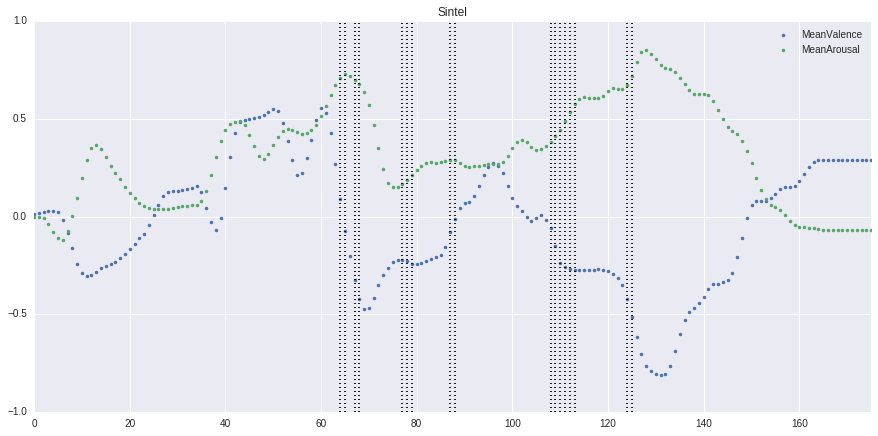

In [98]:
f = 'Sintel'
'''
        visualdf = getAvgVisFeatListDf(f,visual_feat_list)
        audiodf = getAudioDf(f)
        deepdf = getAvgVisFeatListDf(f,['fc6'])
        lowdf = getLowFeature10SecDf(f)
        facedf = getFaceFeature(f)
'''
        
df = getAnnotationDf(f)   
annotdf = getFearDf(f)
plt.figure(figsize=(15,7))

df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=f)
for i in range(annotdf.shape[0]):
    if (annotdf['Fear'][i]) >0:
        plt.axvline(x=i,linestyle=':',color='black')



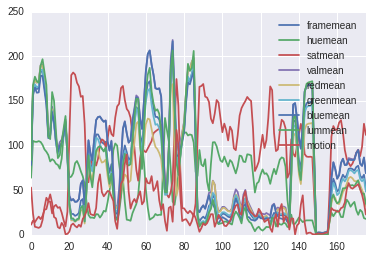

In [99]:
lowdf = getLowFeature10SecDf(f)
lowdf.plot(style='-')

In [100]:
#lowdf[['lummean','motion']].plot()

In [101]:
#plot2graph(lowdf['lummean'],lowdf['motion'])

In [102]:
#plot2graph(df[['MeanValence','MeanArousal']],lowdf['lummean'])

In [103]:
#plot2graph(df['MeanValence'],lowdf['lummean'])

In [104]:
#plotFearDevSet(df, annotdf)

## Ploting Annotations (Fear, arousal,vallence ) 

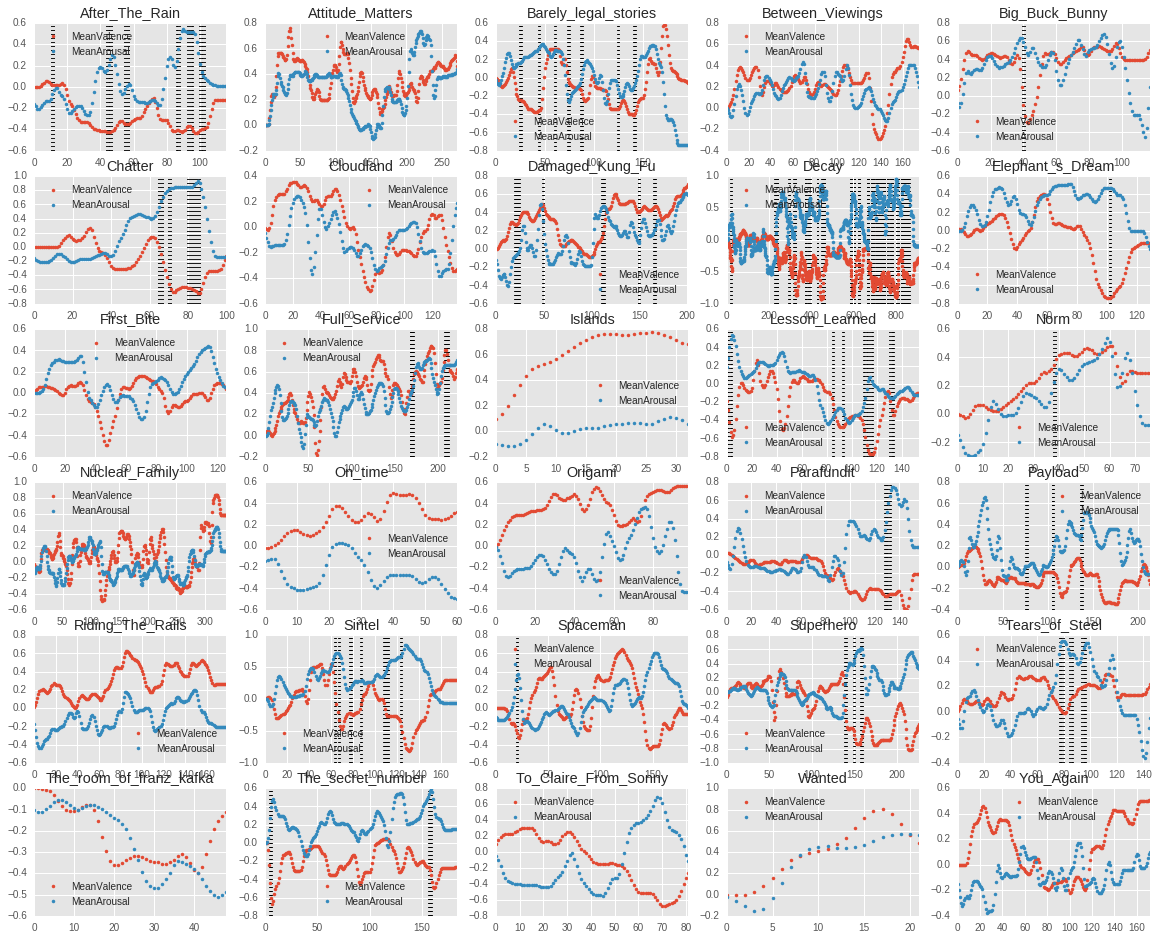

In [83]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    #plt.axis([0, 2000, -1, 1 ])
    df = getAnnotationDf(mov)
    annotdf = getFearDf(mov)
    for i in range(annotdf.shape[0]):
        if (annotdf['Fear'][i]) >0:
            plt.axvline(x=i,linestyle = ':',color='black')
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=mov)


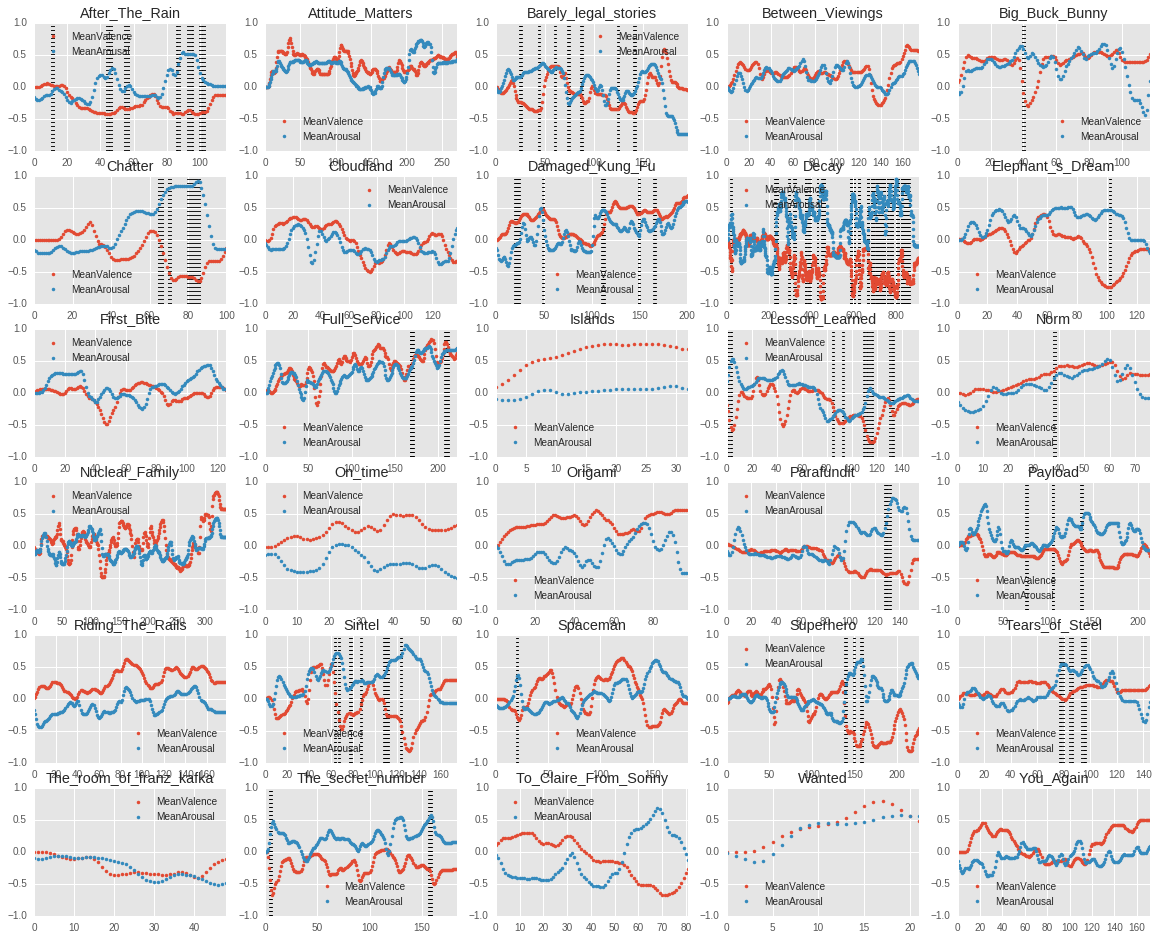

In [84]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    plt.axis([0, 2000, -1, 1 ])
    df = getAnnotationDf(mov)
    annotdf = getFearDf(mov)
    for i in range(annotdf.shape[0]):
        if (annotdf['Fear'][i]) >0:
            plt.axvline(x=i,linestyle = ':',color='black')
    df[['MeanValence','MeanArousal']].plot(ax=plt.gca(),style='.',title=mov)


In [74]:
visual_feat_list= ['acc', 'cedd', 'cl', 'eh', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

def predictFearDevSet(f):
    if (f in movieNames):        
        visualdf = getAvgVisFeatListDf(f,visual_feat_list)
        audiodf = getAudioDf(f)
        deepdf = getAvgVisFeatListDf(f,['fc6'])
        lowdf = getLowFeature10SecDf(f)
        facedf = getFaceFeature(f)
        
        annotdf = getFearDf(f)
        yf = df2mat(annotdf[['Fear']])
        
        print(audiodf.shape,visualdf.shape,deepdf.shape,lowdf.shape,facedf.shape)

        mlen = min([len(audiodf),len(visualdf),len(deepdf),len(lowdf),len(facedf)])

        audiodf = audiodf[:mlen]
        visualdf = visualdf[:mlen]
        deepdf = deepdf[:mlen]
        lowdf = lowdf[:mlen]
        facedf= facedf[:mlen]
        
        yf = yf[:mlen]

        visfear = pvisfear.predict(visualdf)        

        audfear = paudfear.predict(audiodf)     
                
        deepfear = pdeepfear.predict(deepdf)
        
        lowfear = plowfear.predict(lowdf)

        facefear = pfacefear.predict(facedf)
        
        
        df =pd.DataFrame(np.transpose([visfear, audfear, deepfear, lowfear, facefear ]), 
                         columns=['visfear', 'audfear', 'deepfear', 'lowfear', 'facefear'])

    return df

((912, 1583), (912, 1271), (912, 4096), (951, 9), (912, 10))


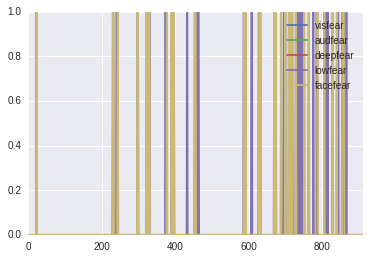

In [77]:
predictFearDevSet('Decay').plot()

((116, 1583), (117, 1271), (117, 4096), (122, 9), (117, 10))
((273, 1583), (273, 1271), (273, 4096), (282, 9), (273, 10))
((196, 1583), (197, 1271), (197, 4096), (205, 9), (196, 10))
((176, 1583), (176, 1271), (176, 4096), (176, 9), (176, 10))
((118, 1583), (118, 1271), (118, 4096), (118, 9), (118, 10))
((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10))
((139, 1583), (139, 1271), (139, 4096), (139, 9), (139, 10))
((201, 1583), (202, 1271), (202, 4096), (202, 9), (202, 10))
((912, 1583), (912, 1271), (912, 4096), (951, 9), (912, 10))
((129, 1583), (130, 1271), (130, 4096), (129, 9), (129, 10))
((127, 1583), (127, 1271), (127, 4096), (127, 9), (127, 10))
((223, 1583), (223, 1271), (223, 4096), (230, 9), (223, 10))
((33, 1583), (34, 1271), (34, 4096), (35, 9), (33, 10))
((154, 1583), (155, 1271), (155, 4096), (160, 9), (154, 10))
((77, 1583), (77, 1271), (77, 4096), (77, 9), (77, 10))
((339, 1583), (339, 1271), (339, 4096), (353, 9), (339, 10))
((61, 1583), (61, 1271), (61, 4096

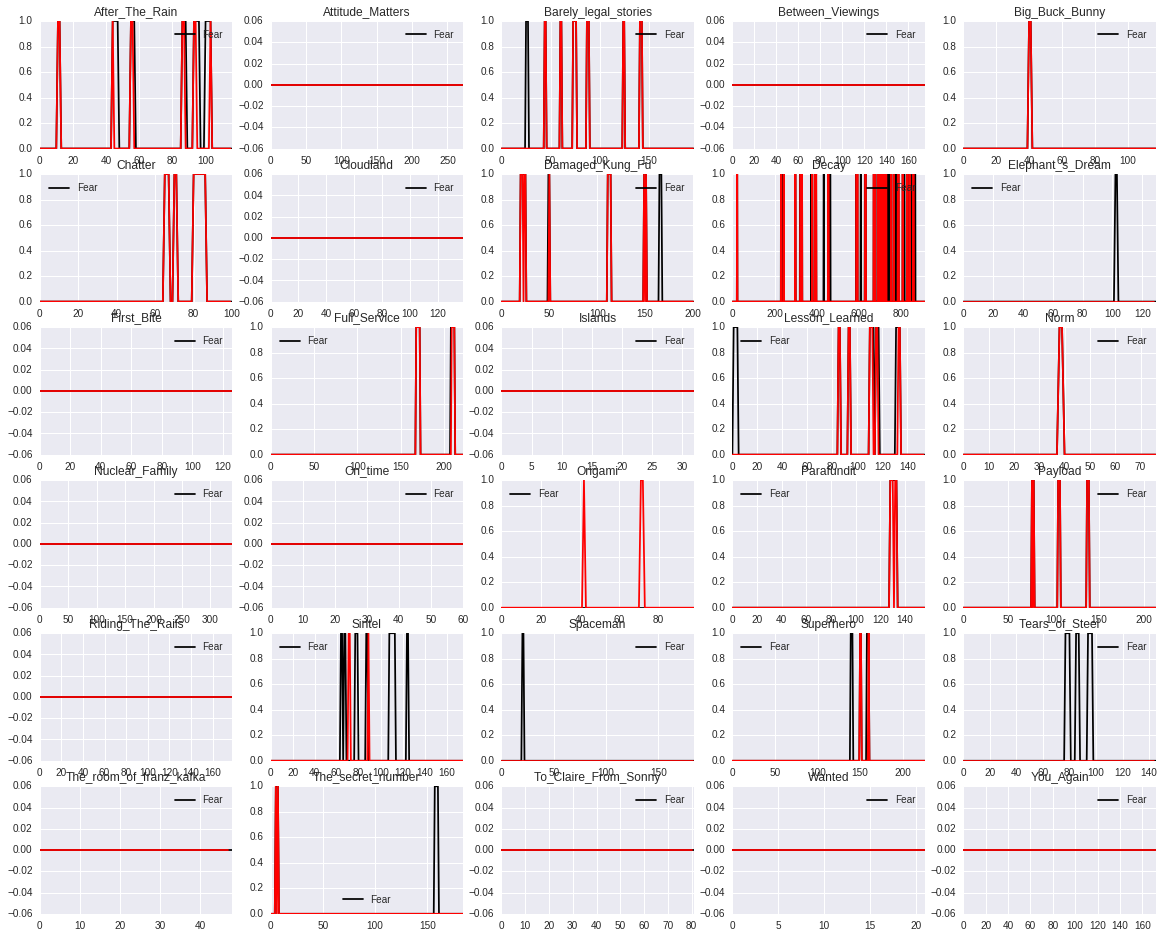

In [80]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),color='black',title=mov)
    predictions = predictFearDevSet(mov)['facefear']
    predictions.plot(ax=plt.gca(),color='red',title=mov)
    
   
    #for i in range(len(cuts)):
    #    x=cuts[i]/5   ## conversion of time to sliding windows with 5 
    #    plt.axvline(x,linestyle='-',color='black')


((116, 1583), (117, 1271), (117, 4096), (122, 9), (117, 10))
((273, 1583), (273, 1271), (273, 4096), (282, 9), (273, 10))
((196, 1583), (197, 1271), (197, 4096), (205, 9), (196, 10))
((176, 1583), (176, 1271), (176, 4096), (176, 9), (176, 10))
((118, 1583), (118, 1271), (118, 4096), (118, 9), (118, 10))
((100, 1583), (101, 1271), (101, 4096), (101, 9), (101, 10))
((139, 1583), (139, 1271), (139, 4096), (139, 9), (139, 10))
((201, 1583), (202, 1271), (202, 4096), (202, 9), (202, 10))
((912, 1583), (912, 1271), (912, 4096), (951, 9), (912, 10))
((129, 1583), (130, 1271), (130, 4096), (129, 9), (129, 10))
((127, 1583), (127, 1271), (127, 4096), (127, 9), (127, 10))
((223, 1583), (223, 1271), (223, 4096), (230, 9), (223, 10))
((33, 1583), (34, 1271), (34, 4096), (35, 9), (33, 10))
((154, 1583), (155, 1271), (155, 4096), (160, 9), (154, 10))
((77, 1583), (77, 1271), (77, 4096), (77, 9), (77, 10))
((339, 1583), (339, 1271), (339, 4096), (353, 9), (339, 10))
((61, 1583), (61, 1271), (61, 4096

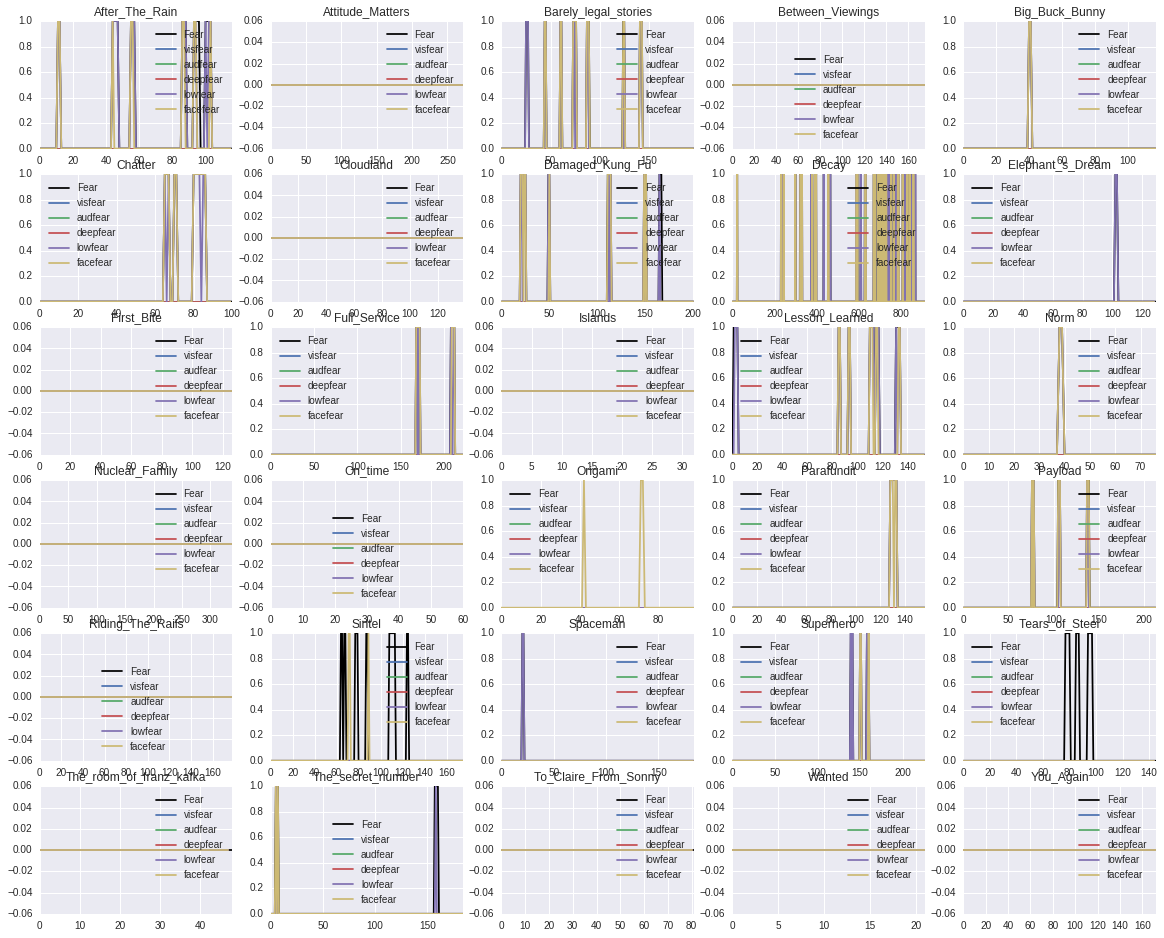

In [87]:
fix, axes = plt.subplots(figsize=(20,16))
for ii, mov in enumerate(movieNames):
    plt.subplot(6,5,ii+1)
    df = getFearDf(mov)
    df[['Fear']].plot(ax=plt.gca(),color='black',title=mov)
    predictions = predictFearDevSet(mov)
    predictions.plot(ax=plt.gca(),title=mov)
    


In [105]:
def predictFearTestSet(f):
    audiodf = getAudioDf(f,folder=med2017audiofolderTest)
    visualdf = getAvgVisFeatListDf(f,visual_feat_list,
                                   folder=med2017visualfolderTest)
    deepdf = getAvgVisFeatListDf(f,['fc6'],
                                    folder=med2017visualfolderTest)
    ## dev set and test set feature are at the same folder
    lowdf = getLowFeature10SecDf(f) 
    facedf = getFaceFeature(f)       
    print(audiodf.shape,visualdf.shape,deepdf.shape,lowdf.shape,facedf.shape)
    mlen = min([len(audiodf),len(visualdf),len(deepdf),len(lowdf),len(facedf)])

    audiodf = audiodf[:mlen]
    visualdf = visualdf[:mlen]
    deepdf = deepdf[:mlen]
    lowdf = lowdf[:mlen]
    facedf= facedf[:mlen]
        
    
    visfear = pvisfear.predict(visualdf)        
    audfear = paudfear.predict(audiodf)                     
    deepfear = pdeepfear.predict(deepdf)        
    lowfear = plowfear.predict(lowdf)
    facefear = pfacefear.predict(facedf)
        
    df =pd.DataFrame(np.transpose([visfear, audfear, deepfear, lowfear, facefear ]),
                     columns=['visfear', 'audfear', 'deepfear', 'lowfear', 'facefear'])

    return df

In [108]:
#pred = predictFearTestSet('MEDIAEVAL17_05')

In [109]:
#pred.plot()

In [110]:
def writeToFile(f,fearpred):
    df = pd.DataFrame(np.transpose([fearpred]), 
                      columns=['Fear'])
    sfilename= f+".csv"
    df.to_csv(sfilename, index=False)

def appendToFile(movie,fname,fearpred):
    fd = open(fname, 'a')
    fd.write(movie+'\n')  # python will convert \n to os.linesep
    fd.close()
    df = pd.DataFrame(np.transpose([fearpred]), columns=['Fear'])
    df.to_csv(fname, sep=' ', index=False, header=False, mode='a')

In [111]:
audiopipefile = './me17ei_audio_fear.txt'
visualpipefile = './me17ei_visual_fear.txt'
deeppipefile = './me17ei_deep_fear.txt'
lowlevelpipefile = './me17ei_lowlevel_fear.txt'
facepipefile = './me17ei_face_fear.txt'


for f in testmovieNames:
    pred = predictFearTestSet(f)
    appendToFile(f,audiopipefile,pred['audfear'])
    appendToFile(f,visualpipefile,pred['visfear'])
    appendToFile(f,deeppipefile,pred['deepfear'])
    appendToFile(f,lowlevelpipefile,pred['lowfear'])
    

NameError: global name 'visual_feat_list' is not defined

In [106]:
for f in testmovieNames:
    appendToFile(f,facepipefile,pred['facefear'])

## svc 

In [ ]:
%%time
lgcv = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgcv.fit(Xtrainv, ytrain)

lgca = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgca.fit(Xtraina, ytrain)

print('Visual SVC :\n {}\n'.format(metrics.classification_report(ytest,lgcv.predict(Xtestv))))
print('Visual SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgcv.predict(Xtestv) , average='macro')))
print('Visual SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgcv.predict(Xtestv))))

print('Audio SVC:\n {}\n'.format(metrics.classification_report(ytest,lgca.predict(Xtesta)))) 
print('Audio SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgca.predict(Xtesta) , average='macro')))
print('Audio SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgca.predict(Xtesta))))

latefusionXtrain = np.transpose([lgcv.predict(Xtrainv),lgca.predict(Xtraina)])

fuslgc = LogisticRegression(C=0.01)
fuslgc.fit(latefusionXtrain,ytrain)

#Test
latefusionXtest = np.transpose([lgcv.predict(Xtestv),lgca.predict(Xtesta)])
pred_ytest = fuslgc.predict(latefusionXtest)

print('Fusion Logistic Regression:\n {}\n'.format(metrics.classification_report(pred_ytest,ytest)))



## grid search

In [ ]:
pipegrad = GradientBoostingClassifier(learning_rate=0.05, 
                           n_estimators=60,max_depth=9,
                           max_features='sqrt', subsample=0.8, 
                           random_state=10) 

In [65]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 1, 10],
     'classifier__C': [0.01, 1, 10,100]}]


grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXv,ty)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
#grid.grid_scores_, grid.best_params_, grid.best_score_

Best params:
{'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier': SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 0.01}

Best cross-validation score: 0.94


In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler()))])

param_grid2 = [{'classifier': [RandomForestClassifier],
     'preprocessing': [None],
     'classifier__n_estimators': [50,100,300],
     'classifier__max_features': [3,5,10]},
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 1, 10],
     'classifier__C': [0.01, 1, 10,100]}]

grid = GridSearchCV(pipe, param_grid, cv=5,n_jobs=4)
grid.fit(tXl,ty)

estimator = RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                   min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_features=’auto’, 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, bootstrap=True, oob_score=False, 
                                   n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                   class_weight=None)

In [147]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}

pipegrad = GradientBoostingClassifier(learning_rate=0.05, 
                           n_estimators=60,max_depth=9,
                           max_features='sqrt', subsample=0.8, 
                           random_state=10) 

gsearch3 = GridSearchCV(pipegrad , param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(Xtraina,ytrain)
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score

In [155]:
X_train, X_test, y_train, y_test = train_test_split(tXv, ty,test_size=0.2, random_state=0)

In [156]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(tXa, ty,test_size=0.2, random_state=0)

In [157]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(tXd, ty,test_size=0.2, random_state=0)

In [158]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(tXl, ty,test_size=0.2, random_state=0)
Xl_train.shape, Xl_test.shape, yl_train.shape, yl_test.shape

((3620, 9), (906, 9), (3620, 1), (906, 1))

((22, 1583), (22, 1271), (22, 4096), (22, 9))
(22, 4)


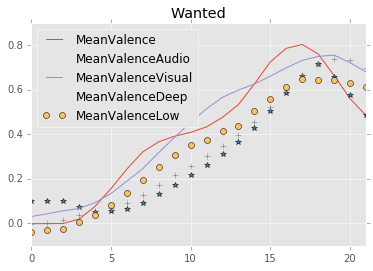

In [131]:
mov = 'Wanted'
df = predictEmo(mov)
dfa = getAnnotationDf(mov)
print dfa.shape

dfa[['MeanValence']].plot(ax=plt.gca(),title=mov)

df[['MeanValenceAudio']].plot(ax=plt.gca(), style=['*'], title=mov)
df[['MeanValenceVisual']].plot(ax=plt.gca(), style=['-'], title=mov)
df[['MeanValenceDeep']].plot(ax=plt.gca(), style=['+'], title=mov)
df[['MeanValenceLow']].plot(ax=plt.gca(), style=['o'], title=mov)


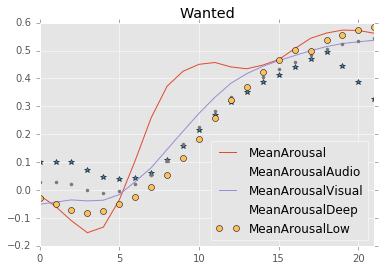

In [136]:
dfa[['MeanArousal']].plot(ax=plt.gca(),title=mov)

df[['MeanArousalAudio']].plot(ax=plt.gca(), style=['*'], title=mov)
df[['MeanArousalVisual']].plot(ax=plt.gca(), style=['-'], title=mov)
df[['MeanArousalDeep']].plot(ax=plt.gca(), style=['.'], title=mov)
df[['MeanArousalLow']].plot(ax=plt.gca(), style=['o'], title=mov)
